In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.keras import TqdmCallback
import glob
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from sklearn import preprocessing
from collections import Counter
from numpy import where
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold
import keras.backend as K

os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

In [6]:
output_path = "/content/drive/MyDrive/labelled data/"

#omit participant p02, p18 and p20
participants = ["p" + str(i).zfill(2) for i in range(0, 25) if i != 2 and i != 18 and i != 20]
print(participants)

['p00', 'p01', 'p03', 'p04', 'p05', 'p06', 'p07', 'p08', 'p09', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p19', 'p21', 'p22', 'p23', 'p24']


#**Pre-processing with StandardScaler()**

In [ ]:
def s(samples):
    std = np.std(samples)
    if std == 0:
        return samples - np.mean(samples)
    else:
        return (samples - np.mean(samples)) / std

def preprocess(df):
  scaler = preprocessing.StandardScaler() #MinMaxScaler
  df_drop = df.drop(['label'], axis=1)
  names = df_drop.columns
  fit = scaler.fit_transform(df_drop)
  scaled_df = pd.DataFrame(fit, columns=names)
  df_new = pd.concat([df['label'],scaled_df], axis = 1)
  return df_new

#**Segmentation with window size 30 (without overlap)**

In [ ]:
eda_freq = 4
temp_freq = 4
hr_freq = 1
bvp_freq = 64
acc_freq = 32

#without overlap
def get_data(pid):
    
    for f in os.listdir(output_path):
        if f.startswith(str(pid)) and f.endswith("EDA.csv"):
            eda_path = f
        elif f.startswith(str(pid)) and f.endswith("TEMP.csv"):
            temp_path = f
        elif f.startswith(str(pid)) and f.endswith("BVP.csv"):
            bvp_path = f
        elif f.startswith(str(pid)) and f.endswith("HR.csv"):
            hr_path = f
        elif f.startswith(str(pid)) and f.endswith("ACC.csv"):
            acc_path = f

    eda_data_raw = pd.read_csv(output_path + eda_path)
    temp_data_raw = pd.read_csv(output_path + temp_path)
    bvp_data_raw = pd.read_csv(output_path + bvp_path)
    hr_data_raw = pd.read_csv(output_path + hr_path)
    acc_data_raw = pd.read_csv(output_path + acc_path)

    eda_data = preprocess(eda_data_raw)
    temp_data = preprocess(temp_data_raw)
    bvp_data = preprocess(bvp_data_raw)
    hr_data = preprocess(hr_data_raw)
    acc_data = preprocess(acc_data_raw)

    eda = []; temp=[]; label=[]; bvp=[]; hr=[]; acc_x=[]; acc_y=[]; acc_z=[]; win_size = 30; 
    
    for i in range(win_size, int(len(bvp_data_raw['bvp']) / bvp_freq)):

        eda.append(s(eda_data['eda'][eda_freq * (i - win_size): eda_freq * i]))

        temp.append(s(temp_data['temp'][temp_freq * (i - win_size): temp_freq * i]))

        bvp.append(s(bvp_data['bvp'][bvp_freq * (i - win_size): bvp_freq * i]))

        hr.append(s(hr_data['bpm'][hr_freq * (i - win_size): hr_freq * i]))

        acc_x.append(s(acc_data['x'][acc_freq * (i - win_size): acc_freq * i]))

        acc_y.append(s(acc_data['y'][acc_freq * (i - win_size): acc_freq * i]))

        acc_z.append(s(acc_data['z'][acc_freq * (i - win_size): acc_freq * i]))

        l = eda_data["label"][eda_freq * (i - win_size): eda_freq * i]
        lp = np.bincount(np.array(l)).argmax()
        label.append(lp)
    
    return {"acc_x": np.array(acc_x, dtype=object),
            "acc_y": np.array(acc_y, dtype=object), 
            "acc_z": np.array(acc_z, dtype=object), 
            "eda": np.array(eda, dtype=object), 
            "temp": np.array(temp, dtype=object), 
            "bvp": np.array(bvp, dtype=object),
            "hr": np.array(hr, dtype=object), 
            "label": np.array(label)}

In [ ]:
all_data = [get_data(pid) for pid in participants]

In [ ]:
for pid in range(len(all_data)):
        print(all_data[pid]['acc_x'].shape) #(samples,960)
        print(all_data[pid]['acc_y'].shape) #(samples,960)
        print(all_data[pid]['acc_z'].shape) #(samples,960)
        print(all_data[pid]['eda'].shape)   #(samples,120)
        print(all_data[pid]['bvp'].shape)   #(samples,1920)
        print(all_data[pid]['temp'].shape)  #(samples,120)
        print(all_data[pid]['hr'].shape)    #(samples,30)
        print(all_data[pid]['label'].shape) #(samples,)

In [ ]:
#without HR data
all_features = ['eda','bvp','temp','acc_x','acc_y','acc_z']

#**FCN model**

In [ ]:
def classifier(train_dataset):
    models = []
    for feature in all_features:
            
      input_shape = train_dataset[feature].shape[1]

      inputs = keras.layers.Input(shape=(input_shape,1))
    
      conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(inputs)
      conv1 = keras.layers.BatchNormalization()(conv1)
      conv1 = keras.layers.Activation(activation='relu')(conv1)

      conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
      conv2 = keras.layers.BatchNormalization()(conv2)
      conv2 = keras.layers.Activation(activation='relu')(conv2)

      conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
      conv3 = keras.layers.BatchNormalization()(conv3)
      conv3 = keras.layers.Activation(activation='relu')(conv3)

      pooling_layer = tf.keras.layers.GlobalAveragePooling1D()(conv3)
      models.append(tf.keras.Model(inputs=inputs, outputs=pooling_layer))

    concat_layer = tf.keras.layers.concatenate([x.output for x in models])
    dense_layer_1 = tf.keras.layers.Dense(512)(concat_layer)
    dense_layer_1 = tf.keras.layers.Activation(activation='relu')(dense_layer_1)
    output_layer = tf.keras.layers.Dense(3, activation="softmax")(dense_layer_1)

    model = tf.keras.Model(inputs=[x.input for x in models], outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="sparse_categorical_crossentropy", 
                  metrics=['accuracy'])

    return model

In [ ]:
scores = []
acc_per_sub, loss_per_sub = [], []
f1_per_sub, prec_per_sub, rec_per_sub = [], [], []
conf_matrix_per_sub = []

#**Reshape, fit and evaluate the model**

In [ ]:
def FCN(train_dataset, test_dataset):
    
    X_train_smote = {}

    for feature in all_features:
      sm = SMOTE()
      X_train_smote[feature], y_train = sm.fit_resample(train_dataset[feature], train_dataset["label"])


    X_train = []
    for feature in all_features:
        X_train_reshape = X_train_smote[feature].reshape(X_train_smote[feature].shape[0],X_train_smote[feature].shape[1], 1).astype(np.float32)
        X_train.append(X_train_reshape)
    #y_train = train_dataset["label"]

    X_test = []
    for feature in all_features:
        X_test_reshape = test_dataset[feature].reshape(test_dataset[feature].shape[0],test_dataset[feature].shape[1], 1).astype(np.float32)
        X_test.append(X_test_reshape)
    y_test = test_dataset["label"]

    model = classifier(train_dataset)
    
    history = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_test, y_test), verbose=0)

    scores = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print(f'Score : {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
    acc_per_sub.append(scores[1] * 100)
    loss_per_sub.append(scores[0])

    y_pred = np.argmax(model.predict(X_test), axis=1)
    f1_per_sub.append(f1_score(y_test, y_pred, average='weighted'))
    prec_per_sub.append(precision_score(y_test, y_pred, average='weighted'))
    rec_per_sub.append(recall_score(y_test, y_pred, average='weighted'))

    print('F1 score: ', f1_score(y_test, y_pred, average='weighted'))
    print('Precision: ',precision_score(y_test, y_pred, average='weighted'))
    print('Recall: ',recall_score(y_test, y_pred, average='weighted'))

    pd.DataFrame(history.history).plot(figsize=(6, 5))
    plt.show()
        
    cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
    conf_matrix_per_sub.append(cm)
    print(cm)
    ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap='Reds')
    ax.figsize=(5,5)
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    
    ax.xaxis.set_ticklabels(['0','1','2'])
    ax.yaxis.set_ticklabels(['0','1','2'])

    plt.show()

    return conf_matrix_per_sub, acc_per_sub, loss_per_sub, f1_per_sub, prec_per_sub, rec_per_sub

#**Without finetuning test data (LOSO)**



Subject 0
8/8 [==============================] - 0s 14ms/step - loss: 1.2010 - accuracy: 0.4528
Score : loss of 1.2009823322296143; accuracy of 45.27687430381775%
29/29 [==============================] - 1s 5ms/step
F1 score:  0.42859651440418306
Precision:  0.4333692414879287
Recall:  0.4527687296416938


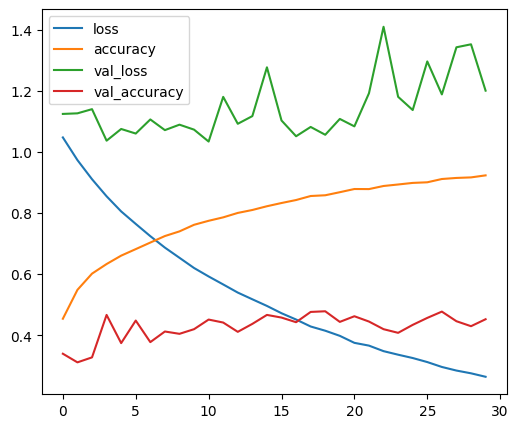

[[128  65 120]
 [145  69 100]
 [ 21  53 220]]


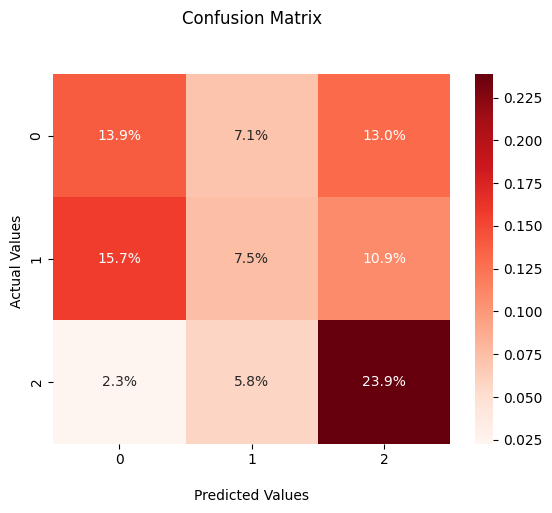

Subject 1
8/8 [==============================] - 0s 14ms/step - loss: 1.6218 - accuracy: 0.4112
Score : loss of 1.6217730045318604; accuracy of 41.11948311328888%
30/30 [==============================] - 1s 5ms/step
F1 score:  0.3505072986869719
Precision:  0.4458585352345451
Recall:  0.41119483315392896


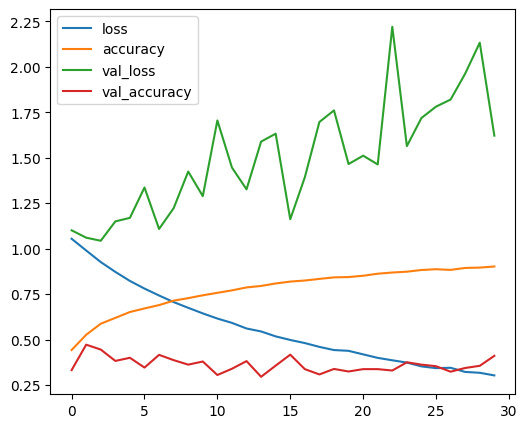

[[111  14 184]
 [ 27  16 275]
 [ 20  27 255]]


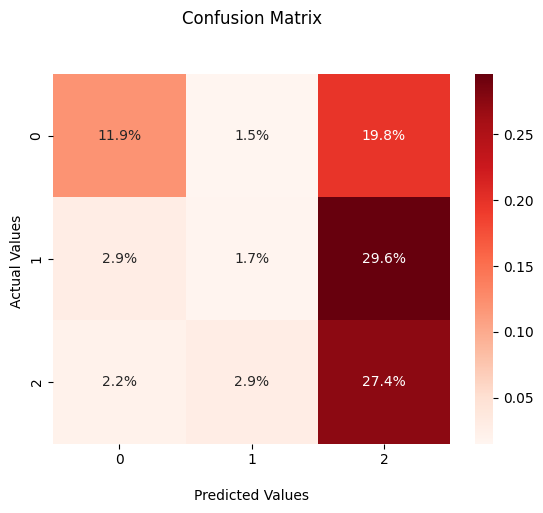

Subject 2
8/8 [==============================] - 0s 14ms/step - loss: 2.0782 - accuracy: 0.3636
Score : loss of 2.078235626220703; accuracy of 36.36363744735718%
29/29 [==============================] - 1s 6ms/step
F1 score:  0.29590872253714745
Precision:  0.43436486369322747
Recall:  0.36363636363636365


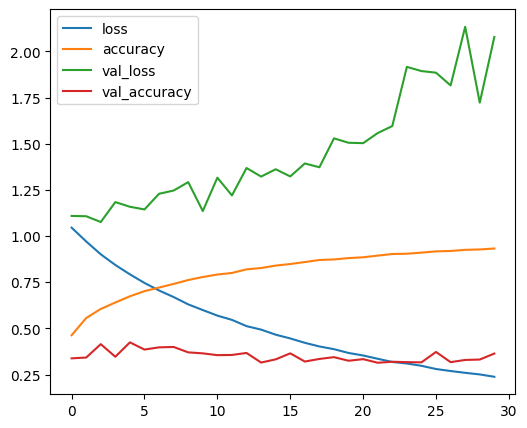

[[ 77 235   0]
 [ 48 246  17]
 [ 17 271  13]]


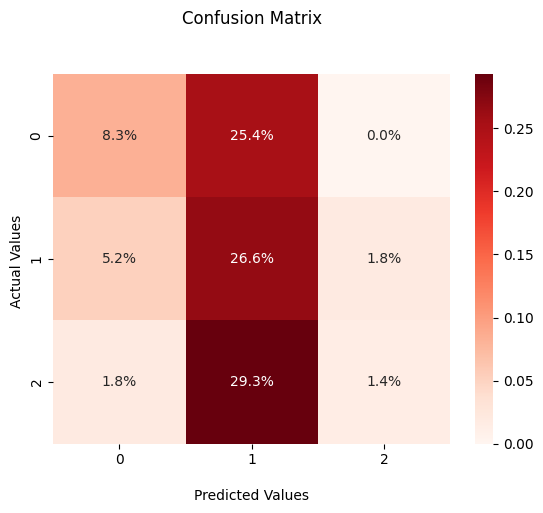

Subject 3
8/8 [==============================] - 0s 14ms/step - loss: 1.7267 - accuracy: 0.4593
Score : loss of 1.7267374992370605; accuracy of 45.928338170051575%
29/29 [==============================] - 1s 5ms/step
F1 score:  0.4176166049383517
Precision:  0.4730303798468477
Recall:  0.4592833876221498


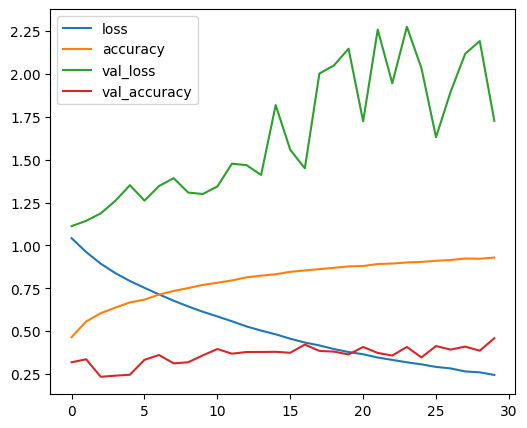

[[183  77  34]
 [123 205   0]
 [118 146  35]]


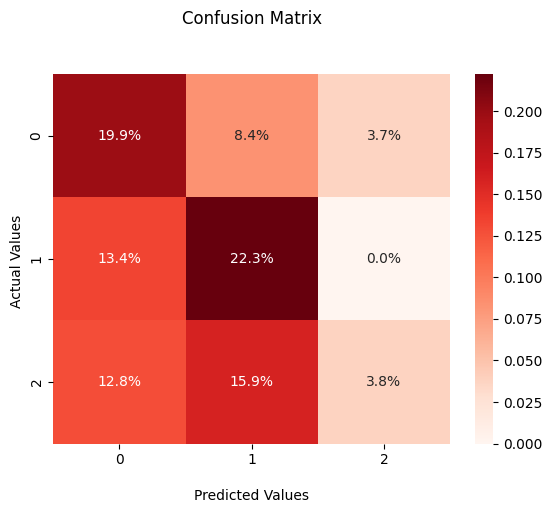

Subject 4
8/8 [==============================] - 0s 15ms/step - loss: 1.6062 - accuracy: 0.2538
Score : loss of 1.6061731576919556; accuracy of 25.382933020591736%
29/29 [==============================] - 1s 5ms/step
F1 score:  0.2479777518154561
Precision:  0.24480545408837184
Recall:  0.2538293216630197


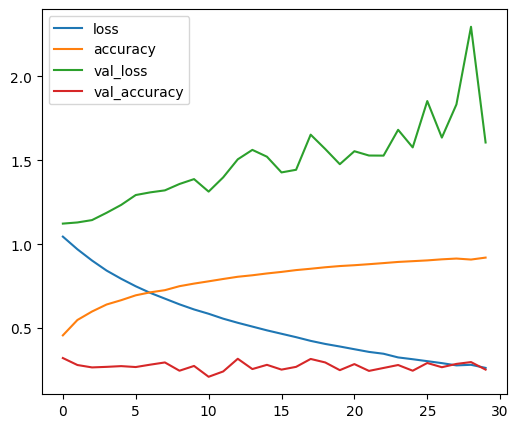

[[ 84  90 121]
 [ 97 115 103]
 [ 97 174  33]]


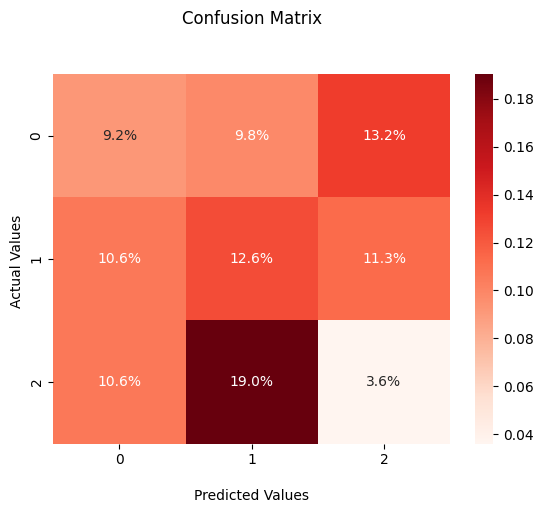

Subject 5
8/8 [==============================] - 0s 14ms/step - loss: 1.6336 - accuracy: 0.4392
Score : loss of 1.6336281299591064; accuracy of 43.92113983631134%
29/29 [==============================] - 1s 5ms/step
F1 score:  0.37980224844075733
Precision:  0.4507465355950428
Recall:  0.43921139101861995


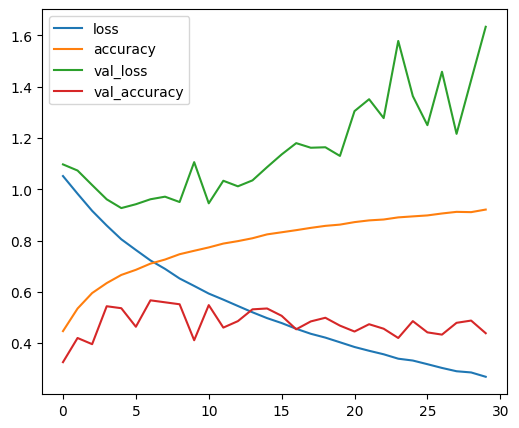

[[252   4  42]
 [182  30 102]
 [152  30 119]]


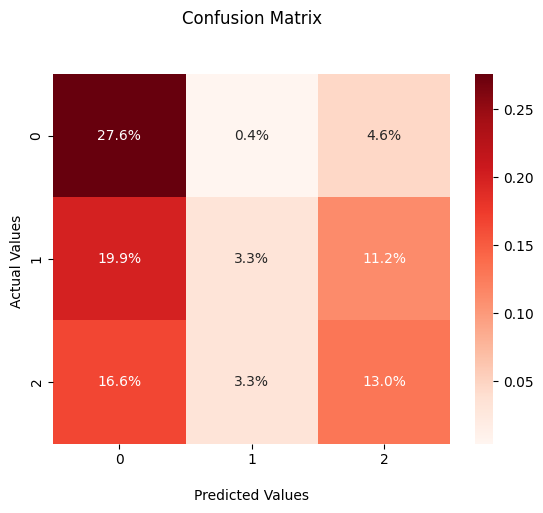

Subject 6
8/8 [==============================] - 0s 14ms/step - loss: 2.4319 - accuracy: 0.4086
Score : loss of 2.431884527206421; accuracy of 40.864863991737366%
29/29 [==============================] - 1s 6ms/step
F1 score:  0.32865794416281435
Precision:  0.2748570525515092
Recall:  0.40864864864864864


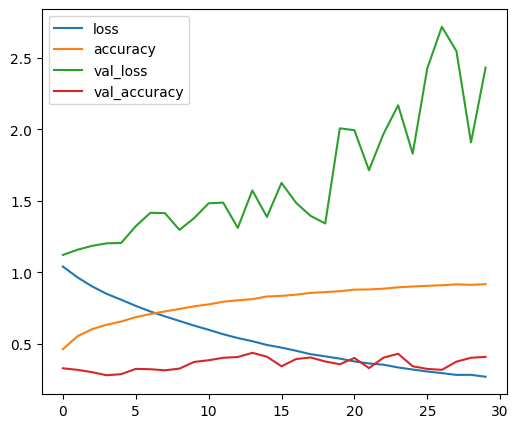

[[211  93   0]
 [143 167   5]
 [ 99 207   0]]


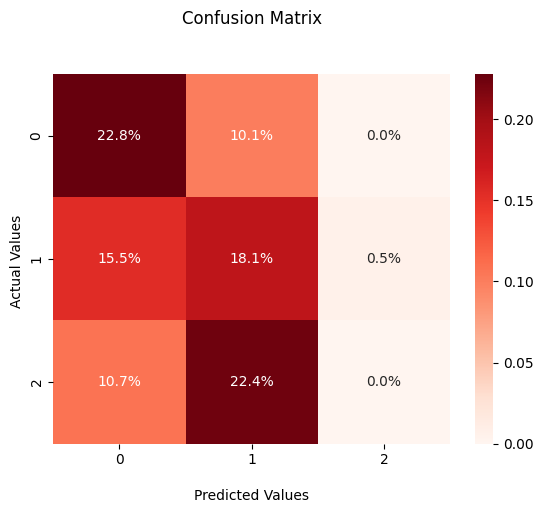

Subject 7
8/8 [==============================] - 0s 14ms/step - loss: 1.8807 - accuracy: 0.4196
Score : loss of 1.8806517124176025; accuracy of 41.956523060798645%
29/29 [==============================] - 1s 5ms/step
F1 score:  0.3516235616256125
Precision:  0.32837273073307904
Recall:  0.41956521739130437


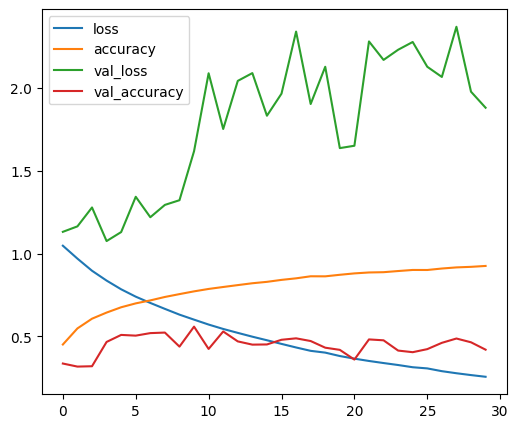

[[258  16  35]
 [244   0  69]
 [ 77  93 128]]


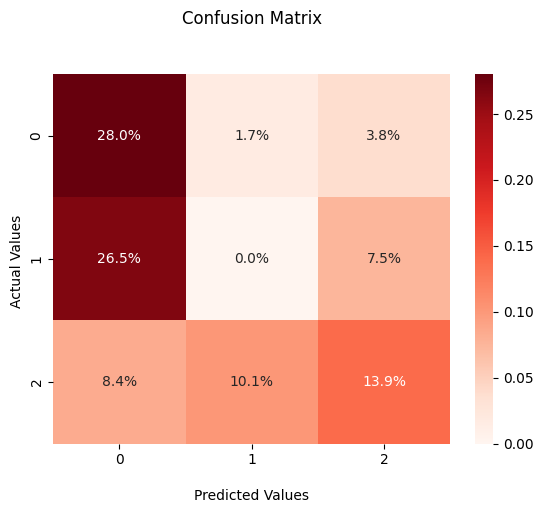

Subject 8
8/8 [==============================] - 0s 15ms/step - loss: 1.9472 - accuracy: 0.2263
Score : loss of 1.9472451210021973; accuracy of 22.630992531776428%
29/29 [==============================] - 1s 5ms/step
F1 score:  0.225296413649651
Precision:  0.3087403284042186
Recall:  0.22630992196209587


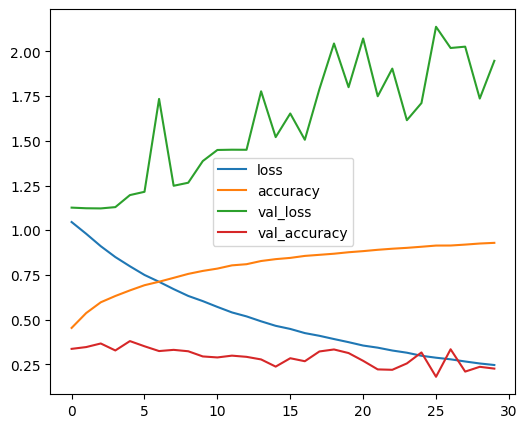

[[ 51  49 202]
 [ 38 139 132]
 [  0 273  13]]


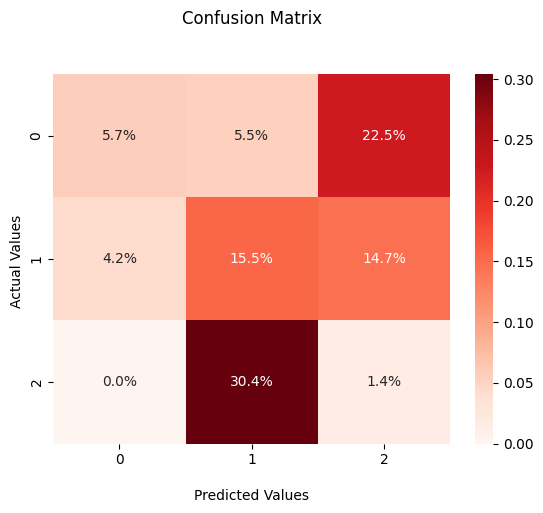

Subject 9
8/8 [==============================] - 0s 16ms/step - loss: 1.8294 - accuracy: 0.3530
Score : loss of 1.8293659687042236; accuracy of 35.30054688453674%
29/29 [==============================] - 1s 7ms/step
F1 score:  0.32015184657732954
Precision:  0.3491481645580007
Recall:  0.35300546448087433


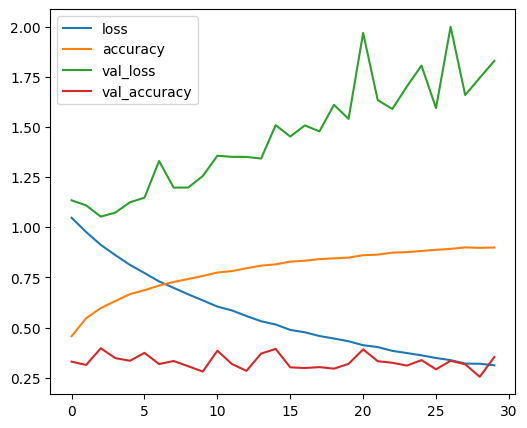

[[196  44  62]
 [125  41 152]
 [183  26  86]]


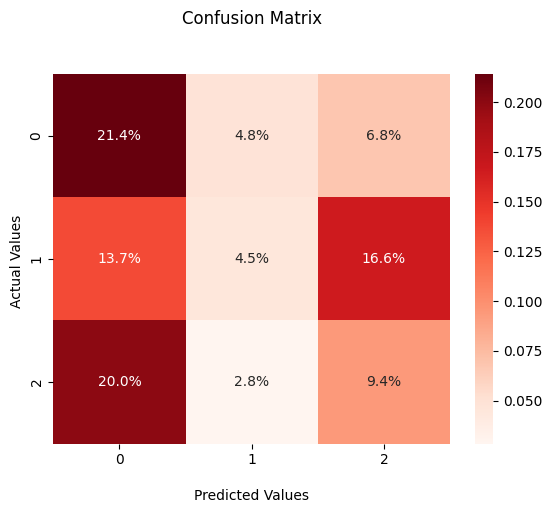

Subject 10
8/8 [==============================] - 0s 14ms/step - loss: 1.8231 - accuracy: 0.3994
Score : loss of 1.8230960369110107; accuracy of 39.93743360042572%
30/30 [==============================] - 1s 6ms/step
F1 score:  0.3734197761703473
Precision:  0.42464912131695454
Recall:  0.3993743482794578


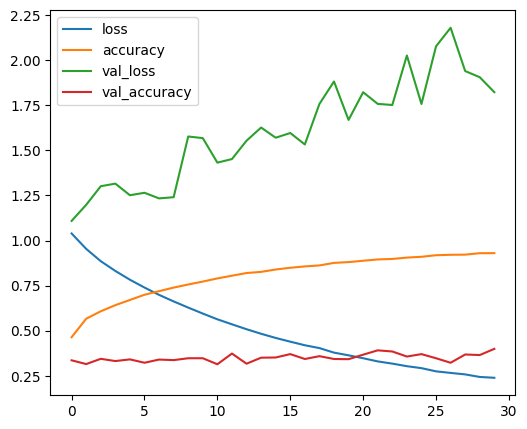

[[231  39  52]
 [143  84  99]
 [218  25  68]]


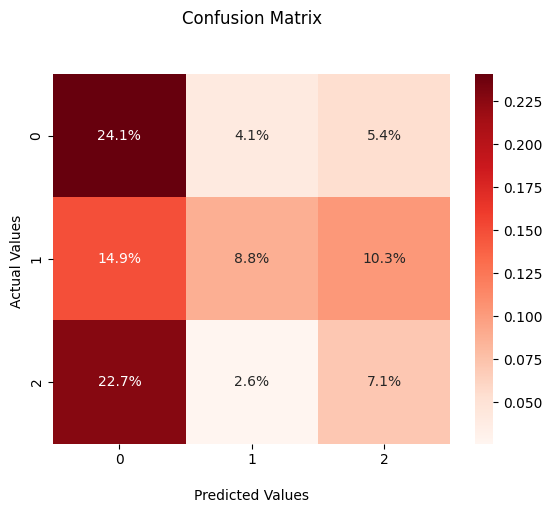

Subject 11
8/8 [==============================] - 0s 15ms/step - loss: 1.4140 - accuracy: 0.4701
Score : loss of 1.4140366315841675; accuracy of 47.01411426067352%
29/29 [==============================] - 1s 6ms/step
F1 score:  0.4338997323427343
Precision:  0.4550221960630084
Recall:  0.47014115092290987


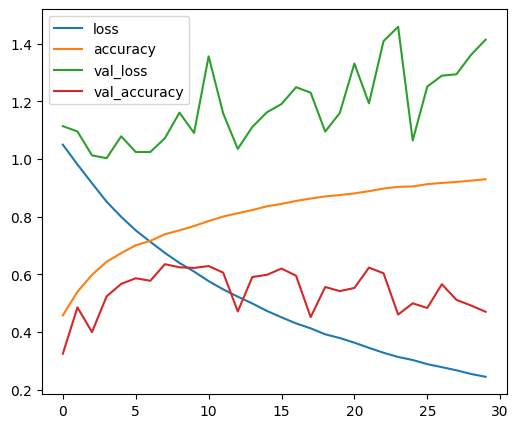

[[268  31   0]
 [162  86  73]
 [ 65 157  79]]


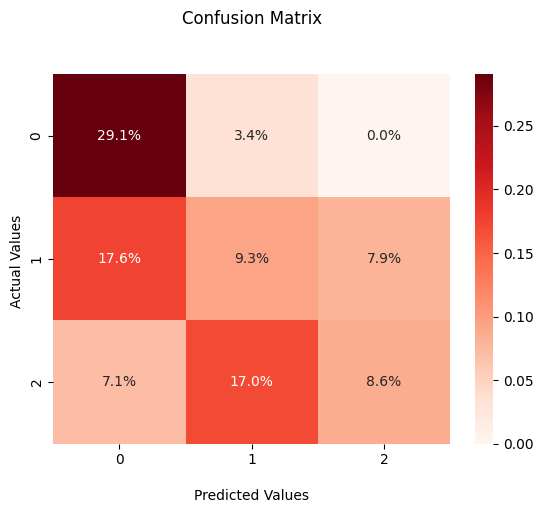

Subject 12
8/8 [==============================] - 0s 14ms/step - loss: 1.1618 - accuracy: 0.6101
Score : loss of 1.1618090867996216; accuracy of 61.01321578025818%
29/29 [==============================] - 1s 6ms/step
F1 score:  0.5925857220109839
Precision:  0.6127724525249916
Recall:  0.6101321585903083


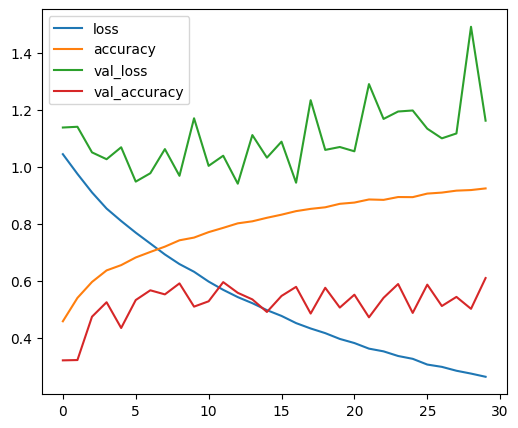

[[221  30  41]
 [136 101  69]
 [ 41  37 232]]


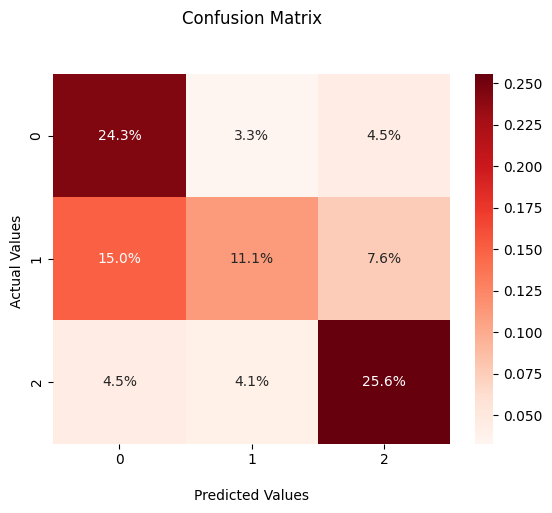

Subject 13
8/8 [==============================] - 0s 14ms/step - loss: 1.9266 - accuracy: 0.4052
Score : loss of 1.926596999168396; accuracy of 40.522876381874084%
29/29 [==============================] - 1s 5ms/step
F1 score:  0.3887548183915278
Precision:  0.41171021771217087
Recall:  0.40522875816993464


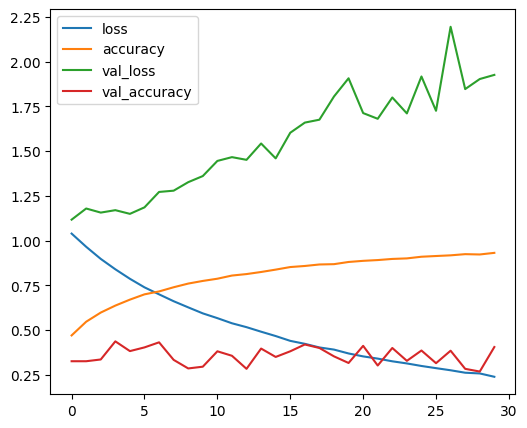

[[191  65  43]
 [130 120  73]
 [181  54  61]]


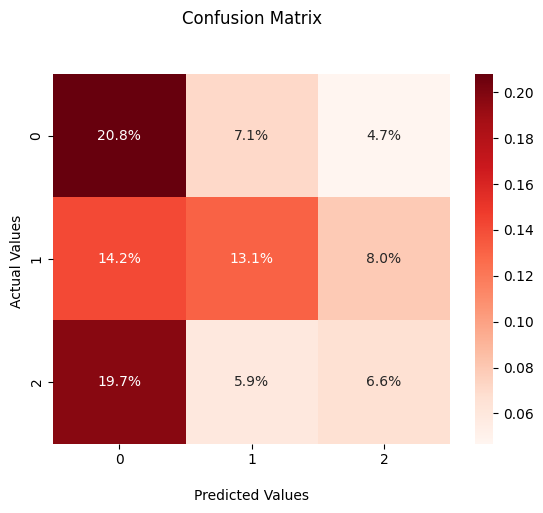

Subject 14
8/8 [==============================] - 0s 16ms/step - loss: 1.8297 - accuracy: 0.3662
Score : loss of 1.8297010660171509; accuracy of 36.624205112457275%
30/30 [==============================] - 1s 6ms/step
F1 score:  0.35272366147778644
Precision:  0.3441975827026749
Recall:  0.3662420382165605


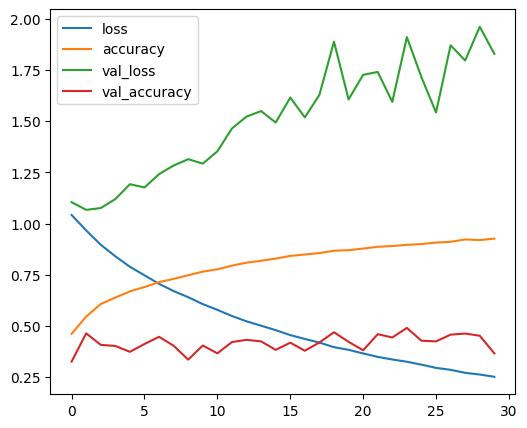

[[189  26  87]
 [168  45 107]
 [ 15 194 111]]


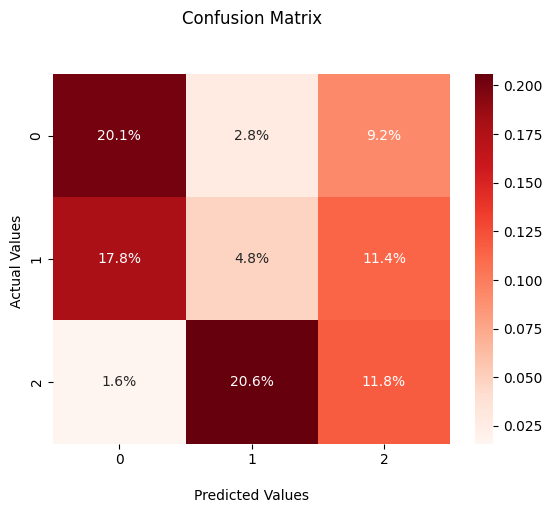

Subject 15
8/8 [==============================] - 0s 14ms/step - loss: 1.2712 - accuracy: 0.4736
Score : loss of 1.2711596488952637; accuracy of 47.356829047203064%
29/29 [==============================] - 1s 5ms/step
F1 score:  0.44845527381947387
Precision:  0.45294098779580255
Recall:  0.473568281938326


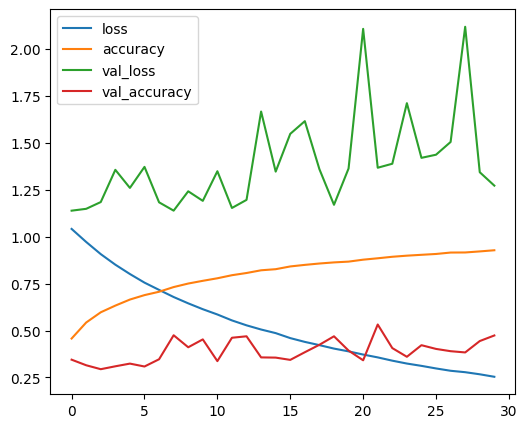

[[173  61  79]
 [174  53  72]
 [ 59  33 204]]


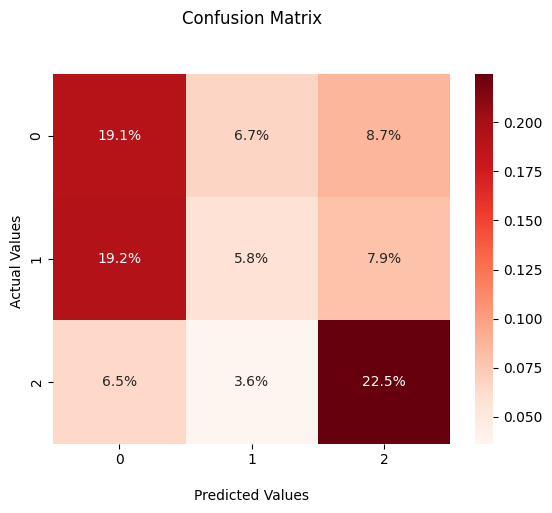

Subject 16
8/8 [==============================] - 0s 15ms/step - loss: 2.6040 - accuracy: 0.3251
Score : loss of 2.60396409034729; accuracy of 32.505398988723755%
29/29 [==============================] - 1s 6ms/step
F1 score:  0.29652530940365
Precision:  0.3009549244581557
Recall:  0.3250539956803456


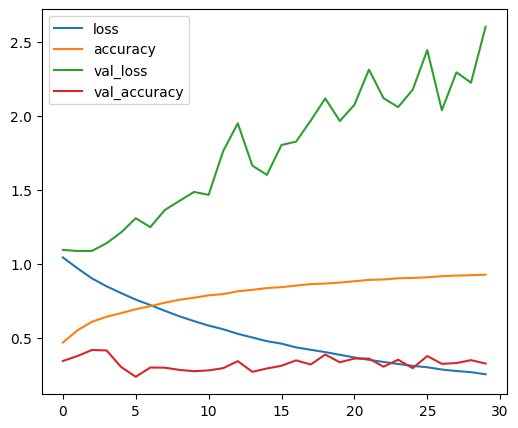

[[156 146  15]
 [124 128  60]
 [ 70 210  17]]


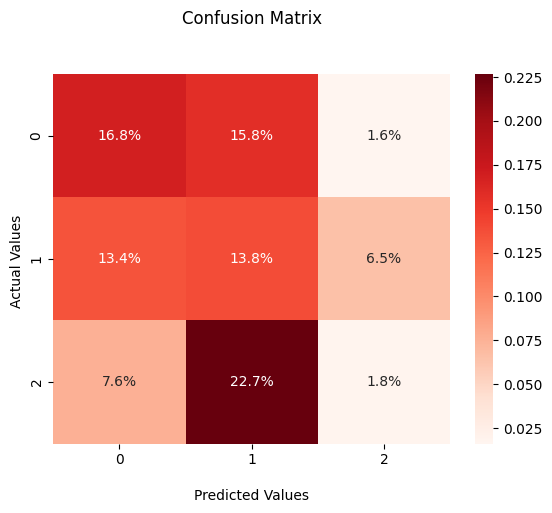

Subject 17
8/8 [==============================] - 0s 14ms/step - loss: 1.6552 - accuracy: 0.4315
Score : loss of 1.6551518440246582; accuracy of 43.147751688957214%
30/30 [==============================] - 1s 6ms/step
F1 score:  0.382783735827936
Precision:  0.4529878314764382
Recall:  0.43147751605995716


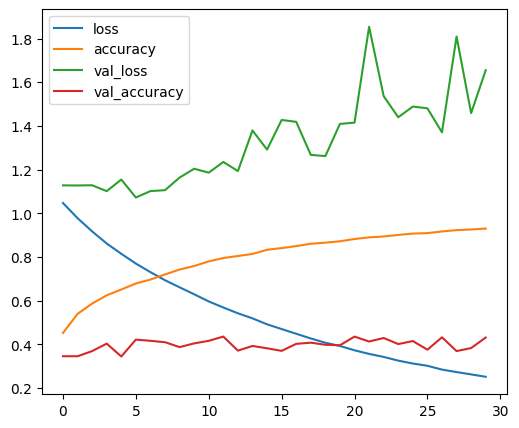

[[100 200  23]
 [ 13 262  34]
 [ 75 186  41]]


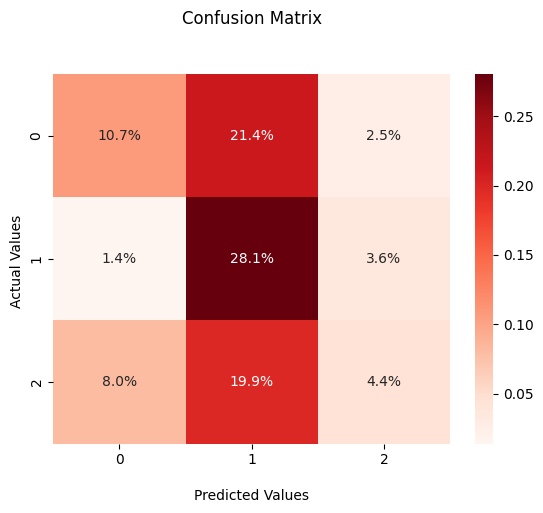

Subject 18
8/8 [==============================] - 0s 14ms/step - loss: 1.3332 - accuracy: 0.4887
Score : loss of 1.3331807851791382; accuracy of 48.86731505393982%
29/29 [==============================] - 1s 5ms/step
F1 score:  0.44429560909733834
Precision:  0.4827670103426309
Recall:  0.4886731391585761


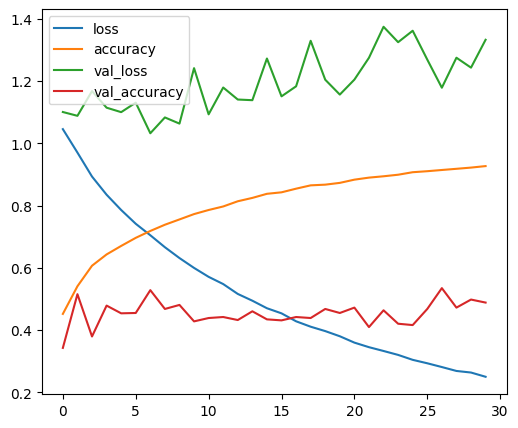

[[ 43 191  84]
 [ 20 246  46]
 [ 36  97 164]]


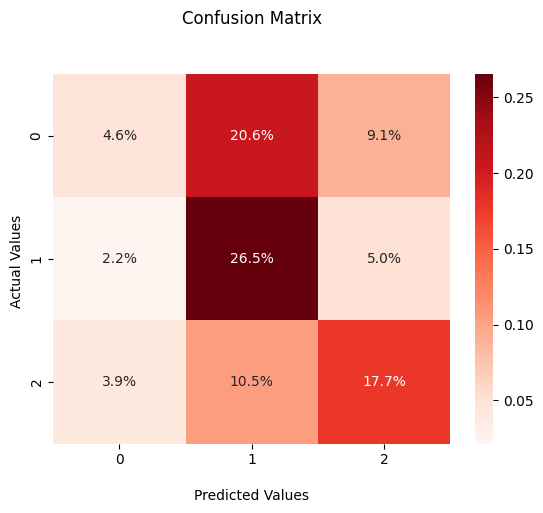

Subject 19
8/8 [==============================] - 0s 14ms/step - loss: 1.2646 - accuracy: 0.5232
Score : loss of 1.2646281719207764; accuracy of 52.323007583618164%
29/29 [==============================] - 1s 5ms/step
F1 score:  0.5305477914622457
Precision:  0.5707908779070048
Recall:  0.5232300884955752


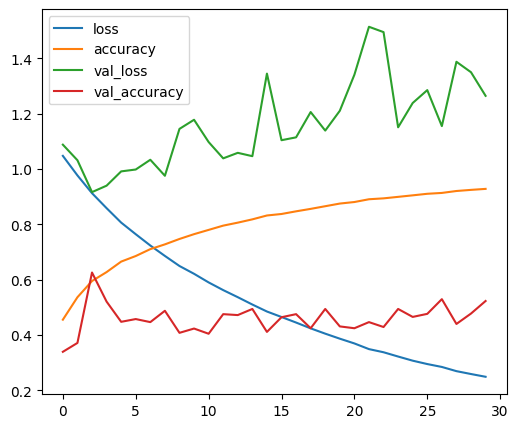

[[170 120  17]
 [ 84 176  44]
 [  6 160 127]]


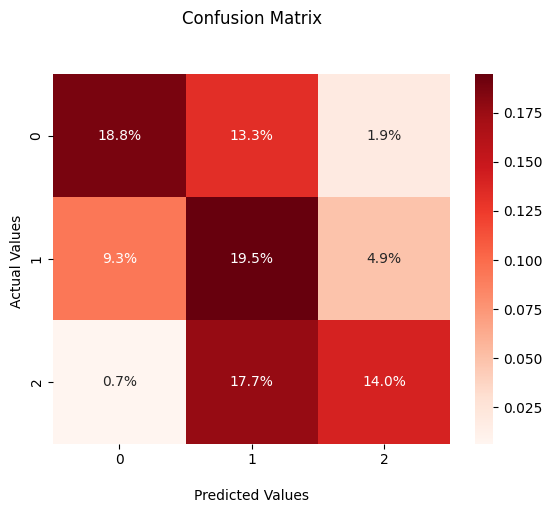

Subject 20
8/8 [==============================] - 0s 14ms/step - loss: 1.9236 - accuracy: 0.4056
Score : loss of 1.9235646724700928; accuracy of 40.56399166584015%
29/29 [==============================] - 1s 5ms/step
F1 score:  0.34806966247901033
Precision:  0.36714327529612745
Recall:  0.40563991323210413


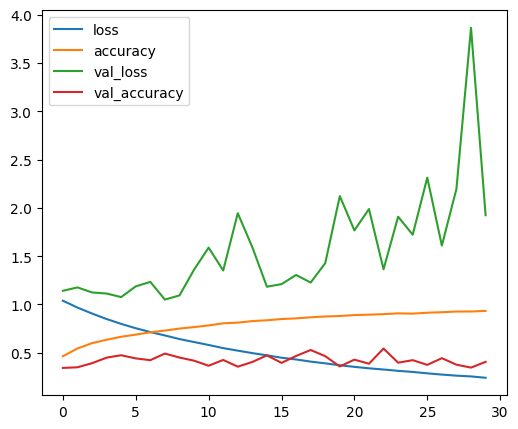

[[235  75   6]
 [134 122  44]
 [210  79  17]]


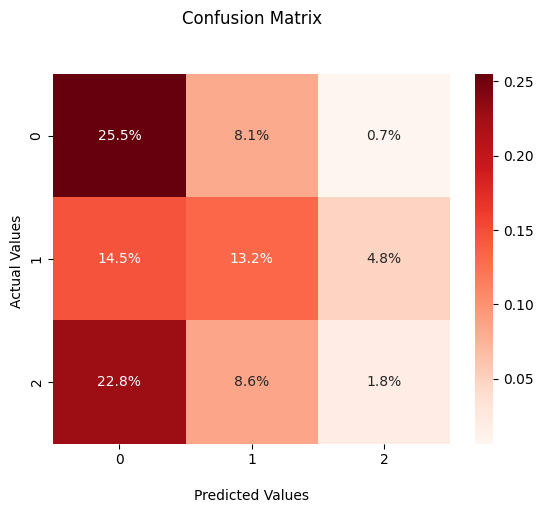

Subject 21
8/8 [==============================] - 0s 15ms/step - loss: 1.4012 - accuracy: 0.3547
Score : loss of 1.4011623859405518; accuracy of 35.4696124792099%
29/29 [==============================] - 1s 5ms/step
F1 score:  0.36085732051986985
Precision:  0.3936776552002946
Recall:  0.3546961325966851


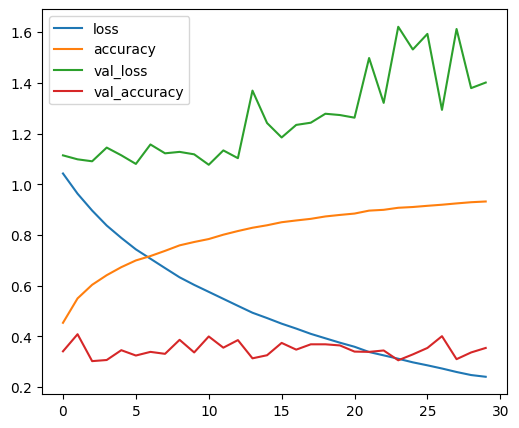

[[100 187  22]
 [ 13  90 199]
 [ 64  99 131]]


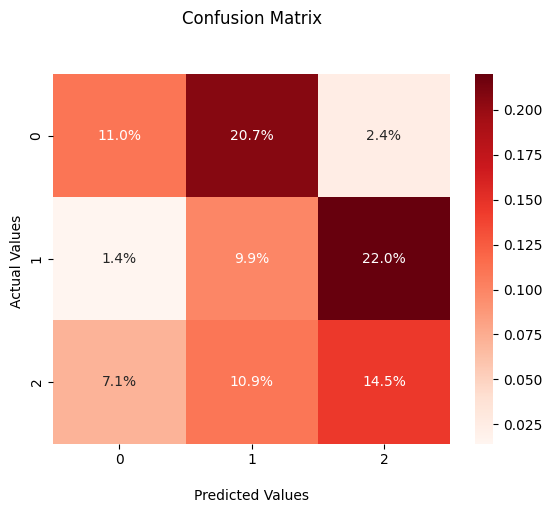

In [ ]:
for sub in range(len(all_data)):
    print('Subject',sub)
    train_data = {}
    
    train_data["acc_x"] = np.concatenate([all_data[i]["acc_x"] for i in range(len(all_data)) if i != sub])
    train_data["acc_y"] = np.concatenate([all_data[i]["acc_y"] for i in range(len(all_data)) if i != sub])
    train_data["acc_z"] = np.concatenate([all_data[i]["acc_z"] for i in range(len(all_data)) if i != sub])

    train_data["eda"] = np.concatenate([all_data[i]["eda"] for i in range(len(all_data)) if i != sub])
    train_data["temp"] = np.concatenate([all_data[i]["temp"] for i in range(len(all_data)) if i != sub])
    train_data["bvp"] = np.concatenate([all_data[i]["bvp"] for i in range(len(all_data)) if i != sub])

    train_data["label"] = np.concatenate([all_data[i]["label"] for i in range(len(all_data)) if i != sub])
    #print('TRAIN SHAPE',train_data['eda'].shape)
    test_data = all_data[sub]
    #print('TEST SHAPE',test_data['eda'].shape)
    cm_w_o_ft, acc_w_o_ft, loss_w_o_ft, f1_w_o_ft, prec_w_o_ft, rec_w_o_ft = FCN(train_data, test_data)

#**Average accuracy and F1 score (no ft)**

In [2]:
# 22 participants accuracy
print(acc_w_o_ft)

[45.27687430381775, 41.11948311328888, 36.36363744735718, 45.928338170051575, 25.382933020591736, 43.92113983631134, 40.864863991737366, 41.956523060798645, 22.630992531776428, 35.30054688453674, 39.93743360042572, 47.01411426067352, 61.01321578025818, 40.522876381874084, 36.624205112457275, 36.624205112457275, 32.505398988723755, 43.147751688957214, 48.86731505393982, 52.323007583618164, 40.56399166584015, 35.4696124792099]


In [12]:
print(np.mean(acc_w_o_ft))
print(np.mean(f1_w_o_ft))

41.09504927288402
0.488072039700451


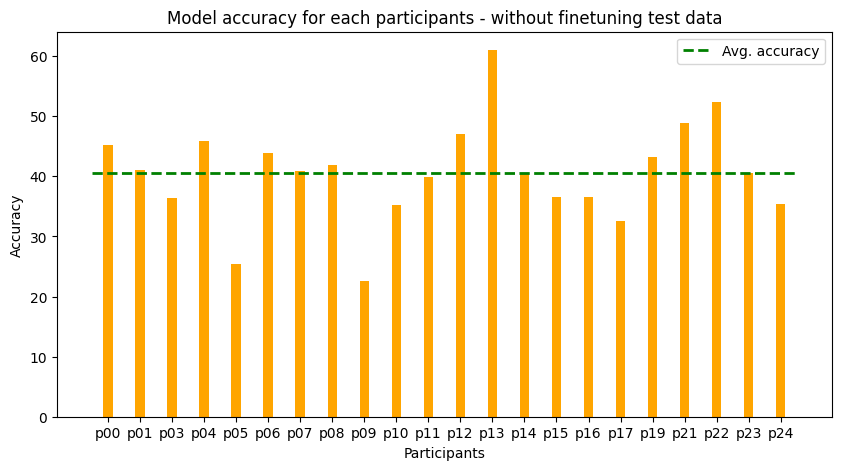

In [23]:
fig = plt.figure(figsize = (10, 5))
 
plt.bar(participants, acc_w_o_ft, color ='orange',width = 0.3)
 
plt.xlabel("Participants")
plt.ylabel("Accuracy")
plt.title("Model accuracy for each participants - without finetuning test data")

plt.hlines(y=(np.mean(acc_w_o_ft)), xmin=-0.5, xmax=(len(acc_w_o_ft)-0.5), colors='green', linestyles='--', lw=2, label='Avg. accuracy')
plt.legend()

plt.show()

#**Finetuning 5% of test data (LOS0)**

SUBJECT 0
7/7 [==============================] - 0s 10ms/step - loss: 1.0439 - accuracy: 0.5160
Score : loss of 1.0439366102218628; accuracy of 51.60183310508728%
28/28 [==============================] - 1s 5ms/step
F1 score:  0.4802789342811875
Precision:  0.5364284983114667
Recall:  0.5160183066361556


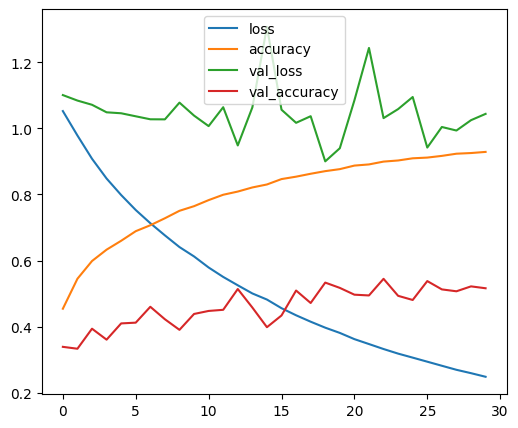

[[ 41 219  36]
 [ 47 227  26]
 [  2  93 183]]


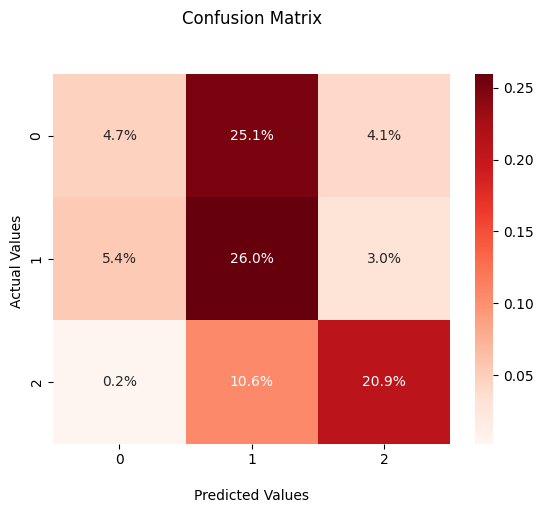

SUBJECT 1
7/7 [==============================] - 0s 10ms/step - loss: 1.1330 - accuracy: 0.4943
Score : loss of 1.1330443620681763; accuracy of 49.43310618400574%
28/28 [==============================] - 1s 5ms/step
F1 score:  0.4890916125893434
Precision:  0.5515322952354922
Recall:  0.4954648526077097


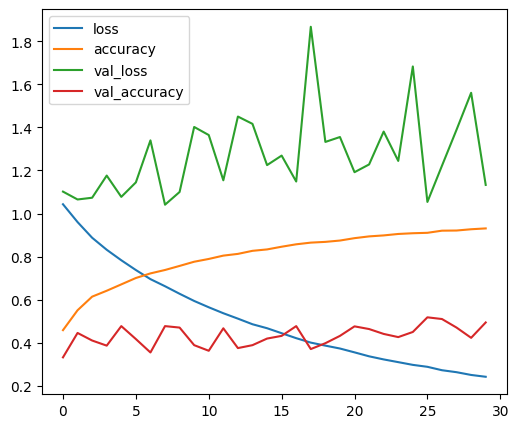

[[ 93  60 140]
 [ 25 157 117]
 [ 10  93 187]]


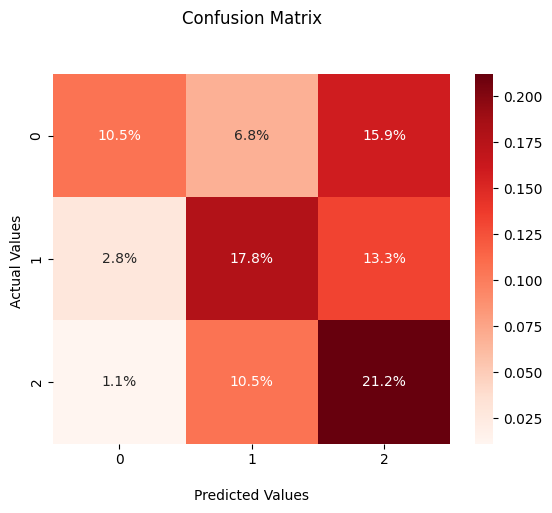

SUBJECT 2
7/7 [==============================] - 0s 10ms/step - loss: 1.4825 - accuracy: 0.4071
Score : loss of 1.4824512004852295; accuracy of 40.70695638656616%
28/28 [==============================] - 1s 5ms/step
F1 score:  0.3725381876808798
Precision:  0.4136534112351475
Recall:  0.4070695553021665


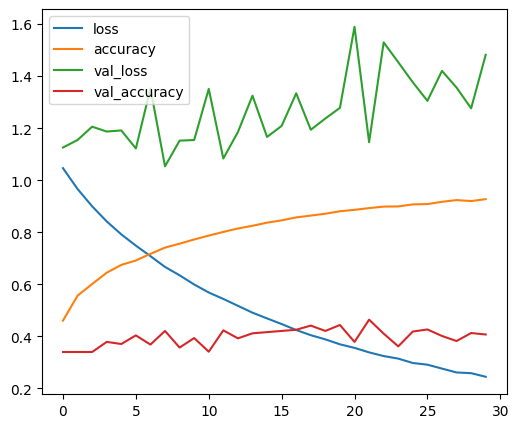

[[152 138   8]
 [ 65 182  44]
 [ 38 227  23]]


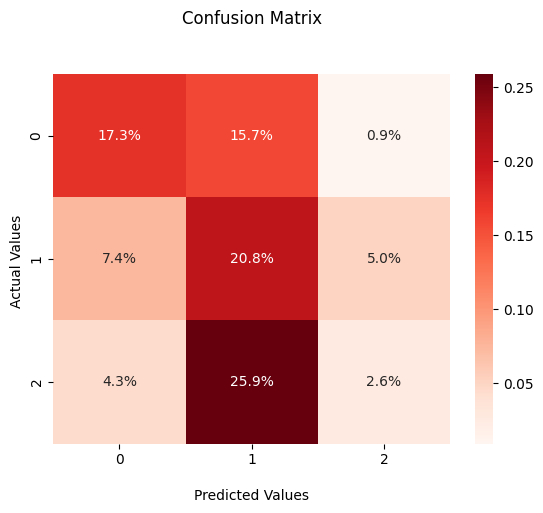

SUBJECT 3
7/7 [==============================] - 0s 10ms/step - loss: 1.1192 - accuracy: 0.5240
Score : loss of 1.1192344427108765; accuracy of 52.40274667739868%
28/28 [==============================] - 1s 4ms/step
F1 score:  0.5161302984453627
Precision:  0.5442619532463635
Recall:  0.5240274599542334


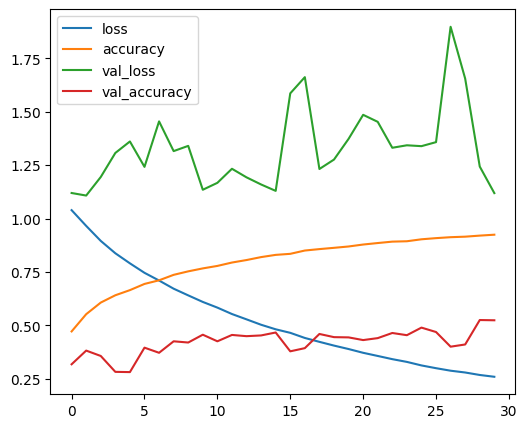

[[184  51  43]
 [117 177  18]
 [ 93  94  97]]


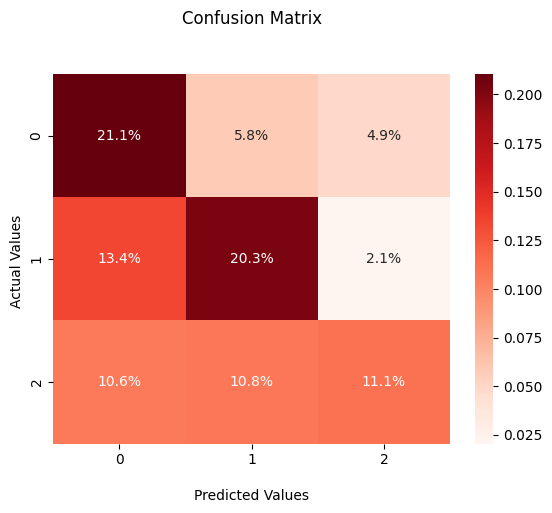

SUBJECT 4
7/7 [==============================] - 0s 10ms/step - loss: 1.8928 - accuracy: 0.3456
Score : loss of 1.8927541971206665; accuracy of 34.562212228775024%
28/28 [==============================] - 1s 5ms/step
F1 score:  0.22918475539088326
Precision:  0.3726904370407056
Recall:  0.3456221198156682


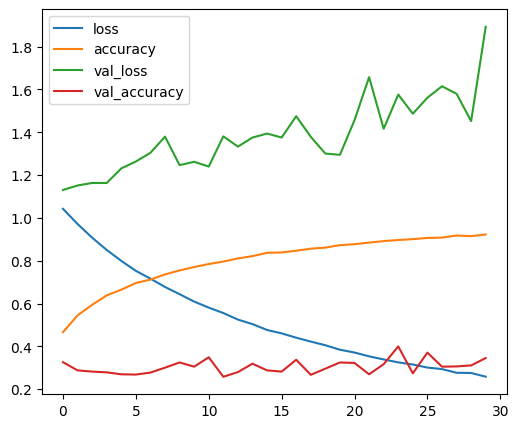

[[ 22 219  42]
 [  0 274  23]
 [  9 275   4]]


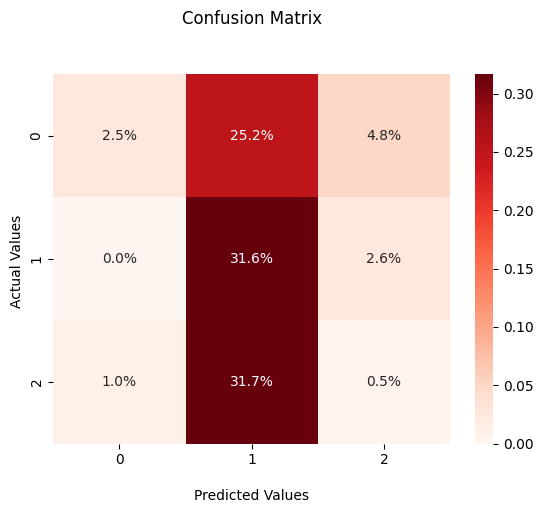

SUBJECT 5
7/7 [==============================] - 0s 10ms/step - loss: 1.3280 - accuracy: 0.4902
Score : loss of 1.3280483484268188; accuracy of 49.01960790157318%
28/28 [==============================] - 1s 5ms/step
F1 score:  0.4547981121963075
Precision:  0.5532092633155727
Recall:  0.49019607843137253


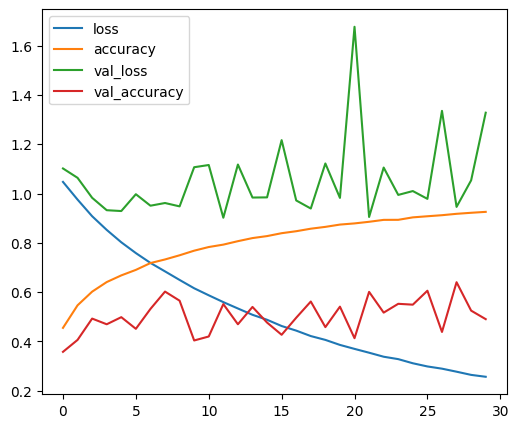

[[258   3  25]
 [191  91  13]
 [140  70  76]]


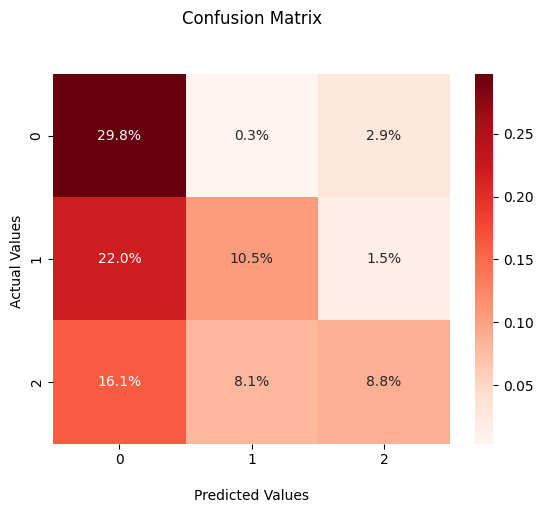

SUBJECT 6
7/7 [==============================] - 0s 10ms/step - loss: 1.7202 - accuracy: 0.5046
Score : loss of 1.720229148864746; accuracy of 50.45558214187622%
28/28 [==============================] - 1s 5ms/step
F1 score:  0.40878777067266797
Precision:  0.3501825983646447
Recall:  0.5045558086560364


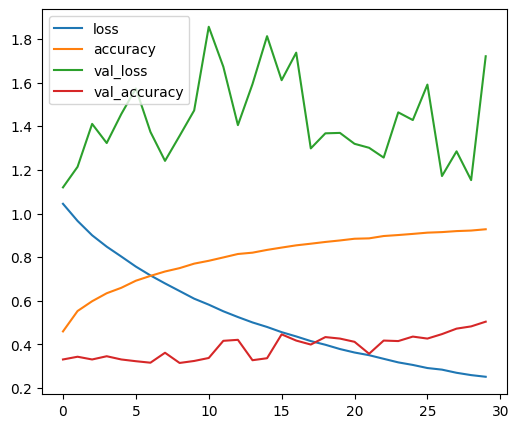

[[211  80   0]
 [ 62 232   1]
 [ 69 223   0]]


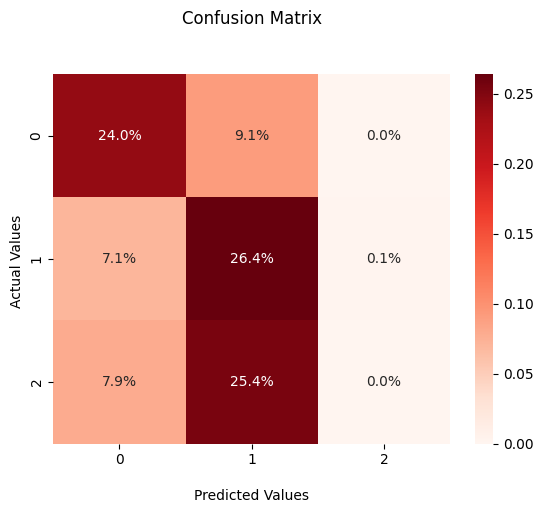

SUBJECT 7
7/7 [==============================] - 0s 10ms/step - loss: 1.8327 - accuracy: 0.4691
Score : loss of 1.8326570987701416; accuracy of 46.91075384616852%
28/28 [==============================] - 1s 4ms/step
F1 score:  0.38024513798842463
Precision:  0.3646248975837345
Recall:  0.4691075514874142


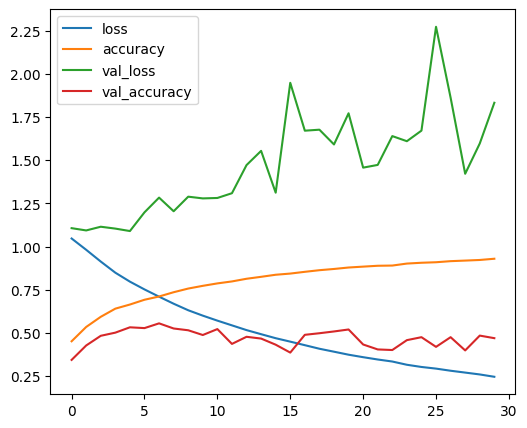

[[173   0 127]
 [127   2 162]
 [ 34  14 235]]


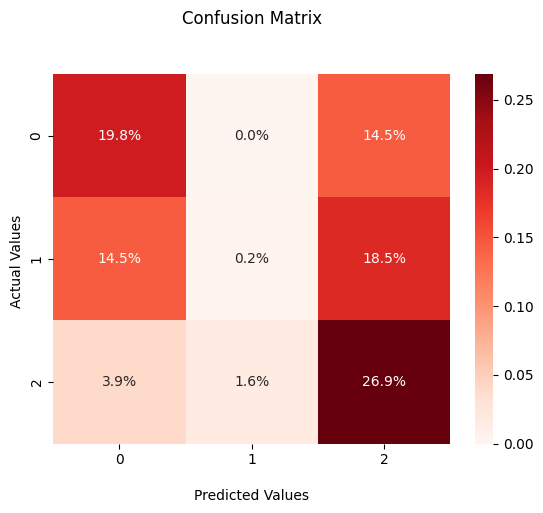

SUBJECT 8
7/7 [==============================] - 0s 10ms/step - loss: 1.4111 - accuracy: 0.4061
Score : loss of 1.4111167192459106; accuracy of 40.61032831668854%
27/27 [==============================] - 1s 5ms/step
F1 score:  0.356803297629908
Precision:  0.3256982815364841
Recall:  0.4061032863849765


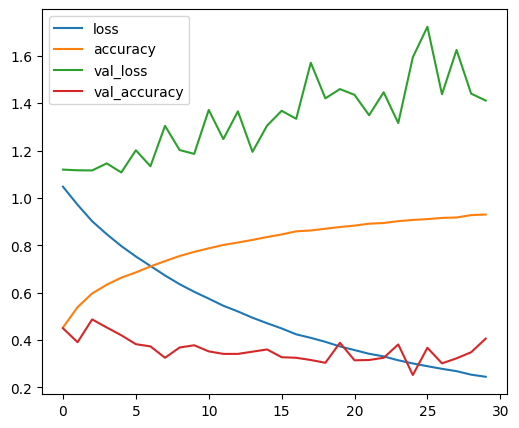

[[217  44  25]
 [103 123  67]
 [ 54 213   6]]


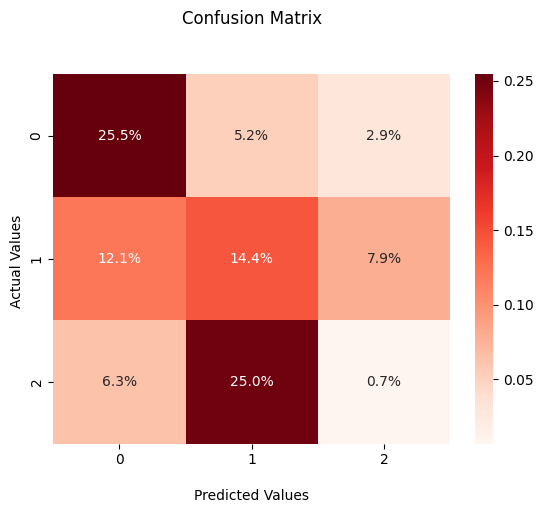

SUBJECT 9
7/7 [==============================] - 0s 10ms/step - loss: 1.7890 - accuracy: 0.4108
Score : loss of 1.7890421152114868; accuracy of 41.081702709198%
28/28 [==============================] - 1s 5ms/step
F1 score:  0.36470355659569637
Precision:  0.37837844416332544
Recall:  0.4108170310701956


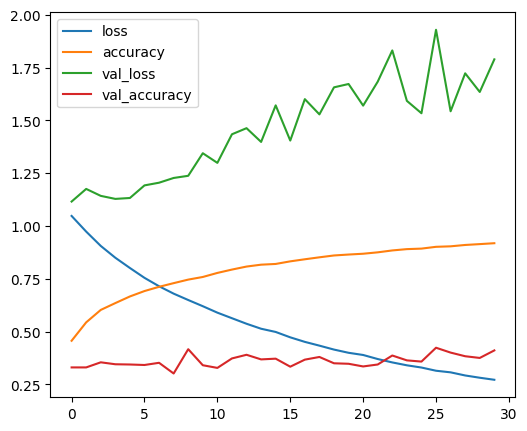

[[222  65   0]
 [129 107  71]
 [158  89  28]]


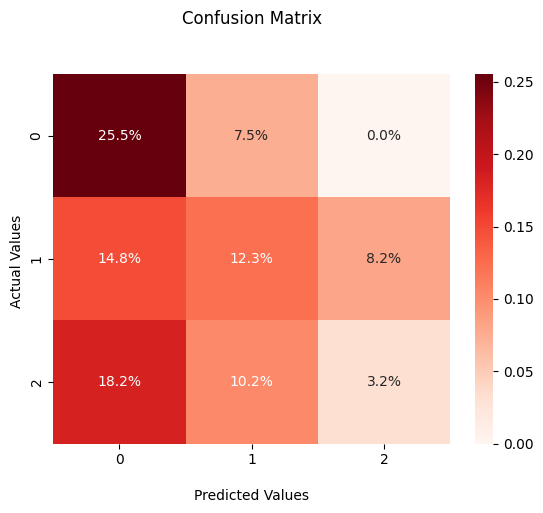

SUBJECT 10
8/8 [==============================] - 0s 9ms/step - loss: 2.0748 - accuracy: 0.3128
Score : loss of 2.0748467445373535; accuracy of 31.284302473068237%
29/29 [==============================] - 1s 4ms/step
F1 score:  0.224090846975683
Precision:  0.27581768642742416
Recall:  0.31284302963776073


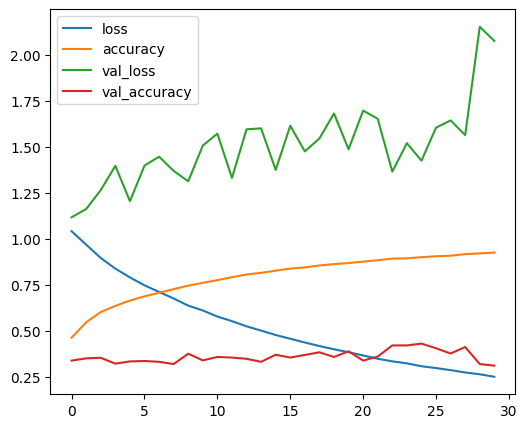

[[247  17  46]
 [215  12  77]
 [261  10  26]]


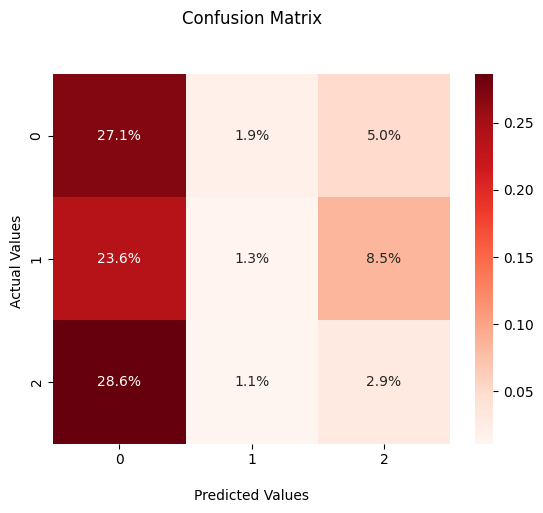

SUBJECT 11
7/7 [==============================] - 0s 10ms/step - loss: 0.9692 - accuracy: 0.5664
Score : loss of 0.9691582322120667; accuracy of 56.636154651641846%
28/28 [==============================] - 1s 4ms/step
F1 score:  0.5419834297210898
Precision:  0.5334464939287276
Recall:  0.5663615560640732


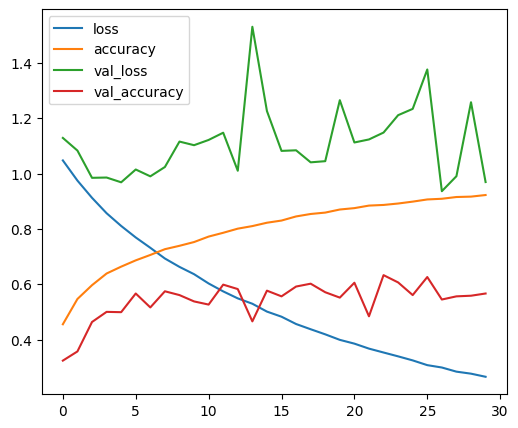

[[240  32  11]
 [121  74 111]
 [  3 101 181]]


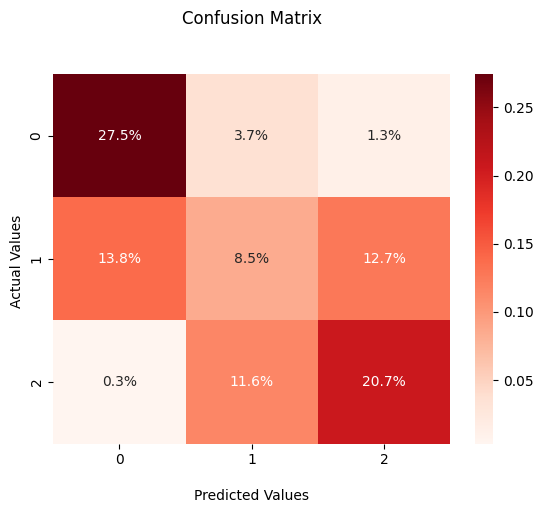

SUBJECT 12
7/7 [==============================] - 0s 10ms/step - loss: 1.0623 - accuracy: 0.5394
Score : loss of 1.0623053312301636; accuracy of 53.944313526153564%
27/27 [==============================] - 1s 5ms/step
F1 score:  0.53126281545093
Precision:  0.6150223404516878
Recall:  0.5394431554524362


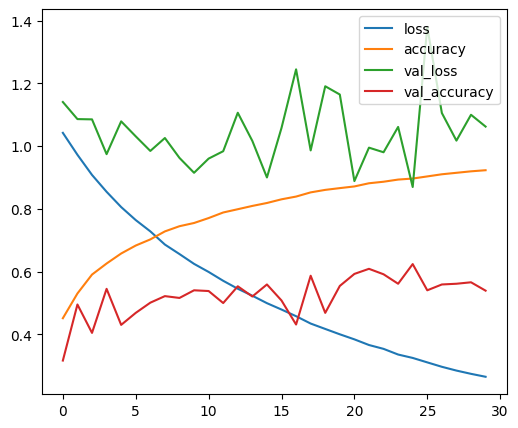

[[225  44   4]
 [150 131  10]
 [ 24 165 109]]


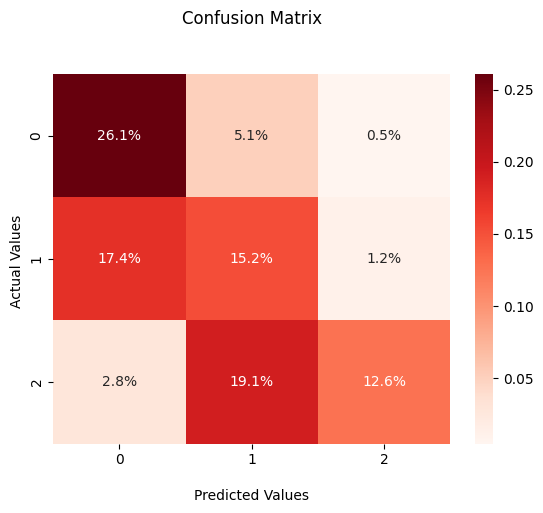

SUBJECT 13
7/7 [==============================] - 0s 10ms/step - loss: 1.6514 - accuracy: 0.4427
Score : loss of 1.6514041423797607; accuracy of 44.26605403423309%
28/28 [==============================] - 1s 5ms/step
F1 score:  0.4171701293374769
Precision:  0.41863557342258895
Recall:  0.4426605504587156


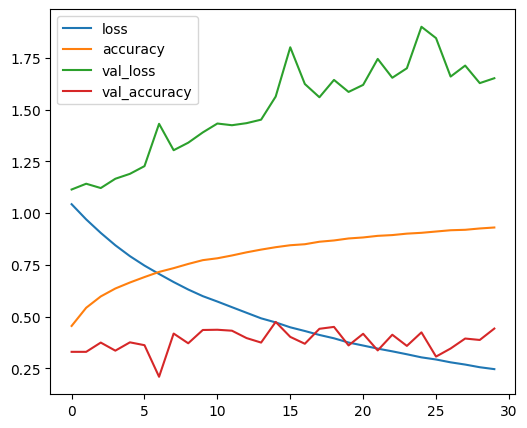

[[142 111  35]
 [ 44 198  60]
 [143  93  46]]


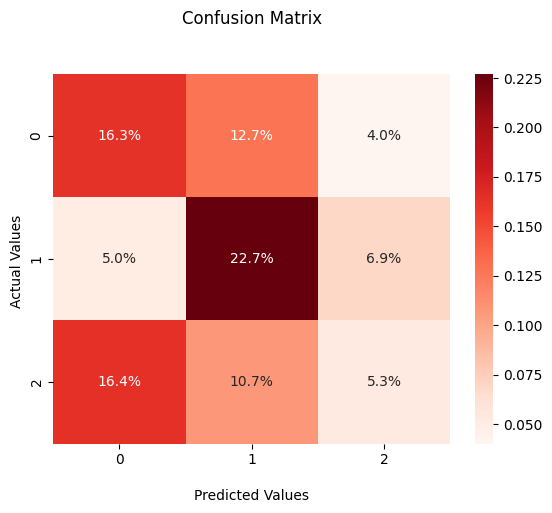

SUBJECT 14
7/7 [==============================] - 0s 10ms/step - loss: 1.4245 - accuracy: 0.4430
Score : loss of 1.4244914054870605; accuracy of 44.29530203342438%
28/28 [==============================] - 1s 4ms/step
F1 score:  0.4086721869919023
Precision:  0.49072211689002493
Recall:  0.4429530201342282


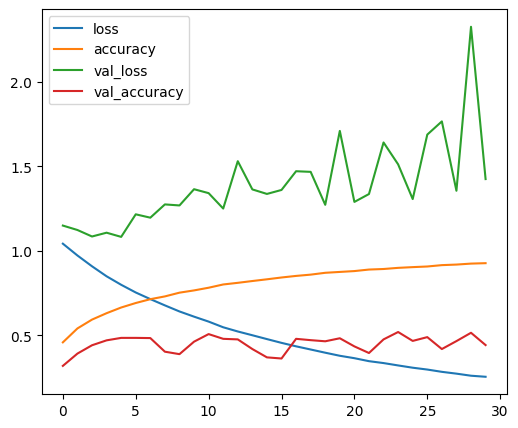

[[238  31  17]
 [181 107  12]
 [  8 249  51]]


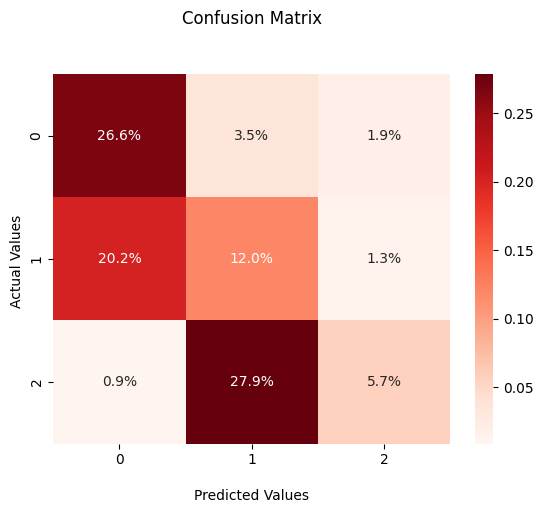

SUBJECT 15
7/7 [==============================] - 0s 10ms/step - loss: 0.9557 - accuracy: 0.5696
Score : loss of 0.9557226300239563; accuracy of 56.96055889129639%
27/27 [==============================] - 1s 4ms/step
F1 score:  0.5453589796376357
Precision:  0.5844997185469063
Recall:  0.5696055684454756


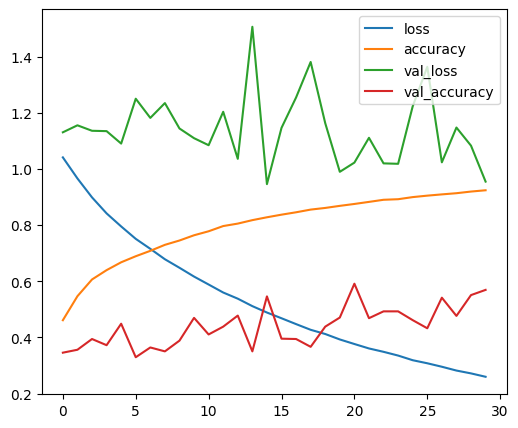

[[170  38  90]
 [112  84  91]
 [ 32   8 237]]


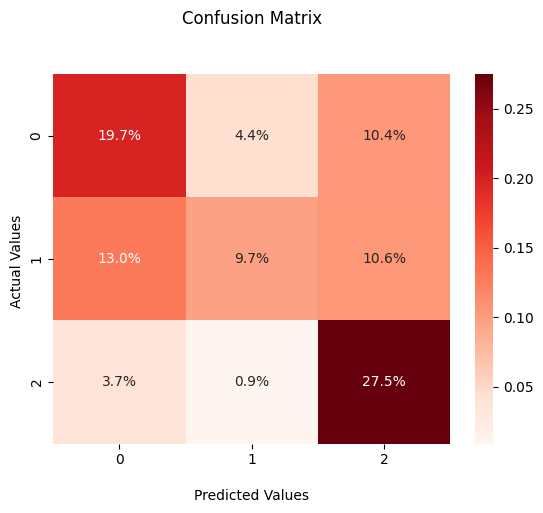

SUBJECT 16
7/7 [==============================] - 0s 10ms/step - loss: 2.3879 - accuracy: 0.4596
Score : loss of 2.3878672122955322; accuracy of 45.96132040023804%
28/28 [==============================] - 1s 4ms/step
F1 score:  0.37616160527261083
Precision:  0.488182101512758
Recall:  0.459613196814562


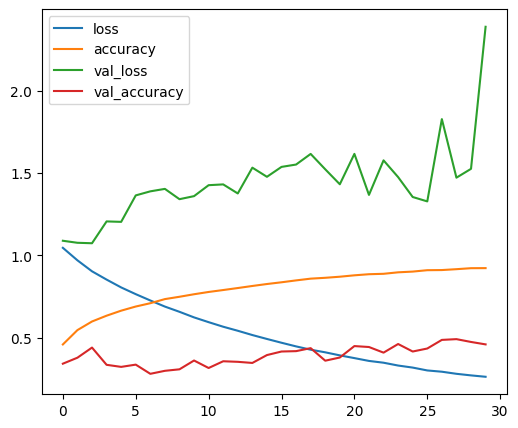

[[284  17   0]
 [171 108  14]
 [211  62  12]]


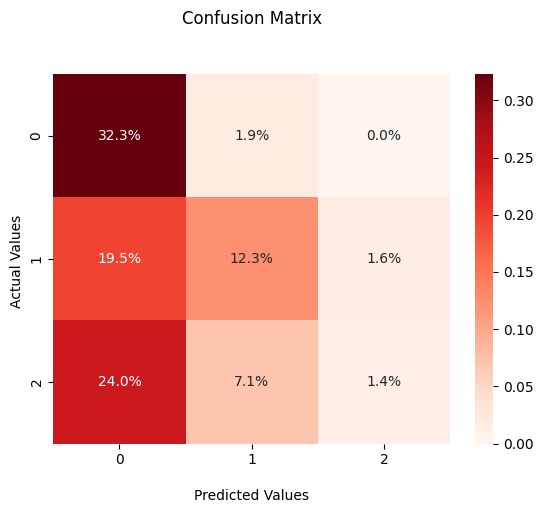

SUBJECT 17
7/7 [==============================] - 0s 10ms/step - loss: 0.9505 - accuracy: 0.5986
Score : loss of 0.9505042433738708; accuracy of 59.86471176147461%
28/28 [==============================] - 1s 5ms/step
F1 score:  0.590152361819815
Precision:  0.5931054351663086
Recall:  0.5986471251409244


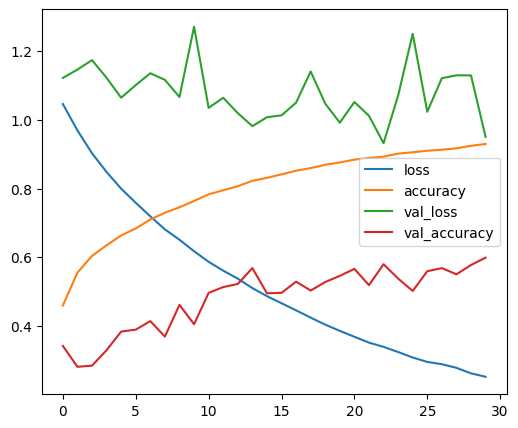

[[204  71  28]
 [ 20 213  65]
 [108  64 114]]


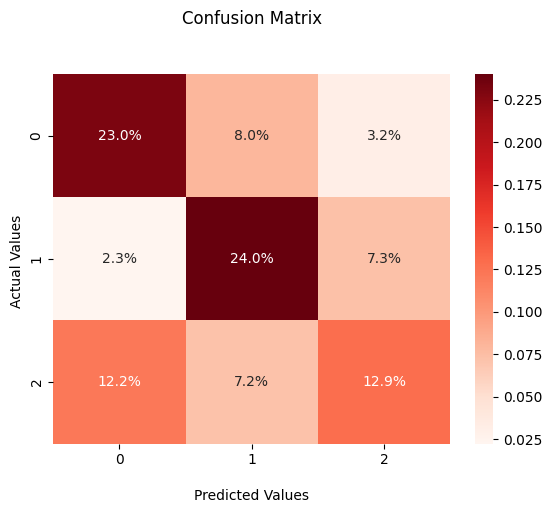

SUBJECT 18
7/7 [==============================] - 0s 11ms/step - loss: 1.3501 - accuracy: 0.4909
Score : loss of 1.350083589553833; accuracy of 49.09090995788574%
28/28 [==============================] - 1s 5ms/step
F1 score:  0.44793187968520065
Precision:  0.4904592894710172
Recall:  0.4909090909090909


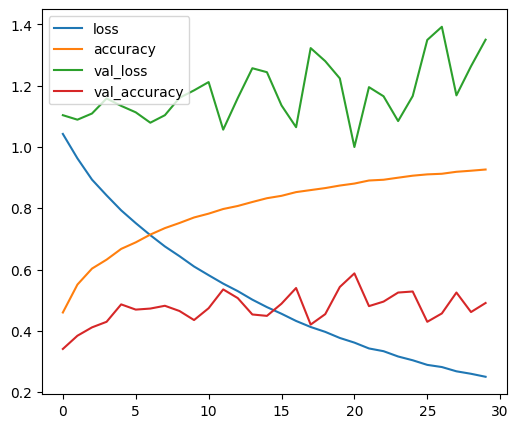

[[183 106  11]
 [ 53 212  28]
 [178  72  37]]


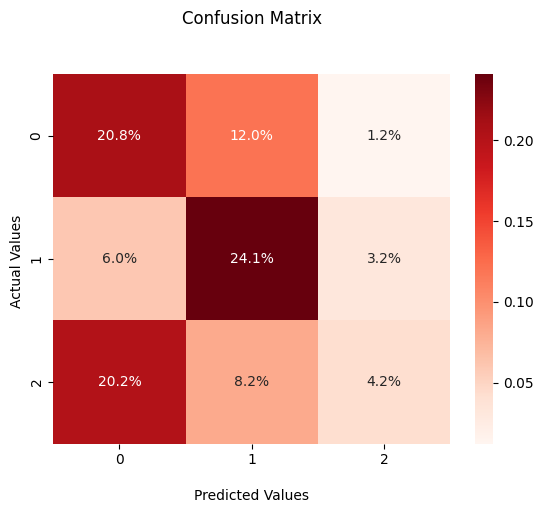

SUBJECT 19
7/7 [==============================] - 0s 10ms/step - loss: 0.8575 - accuracy: 0.6795
Score : loss of 0.857507586479187; accuracy of 67.94871687889099%
27/27 [==============================] - 1s 5ms/step
F1 score:  0.6712473717311346
Precision:  0.6784307970261032
Recall:  0.6794871794871795


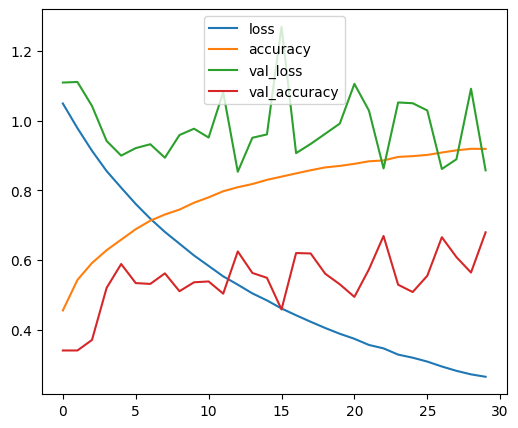

[[224  41  27]
 [ 94 137  58]
 [ 27  28 222]]


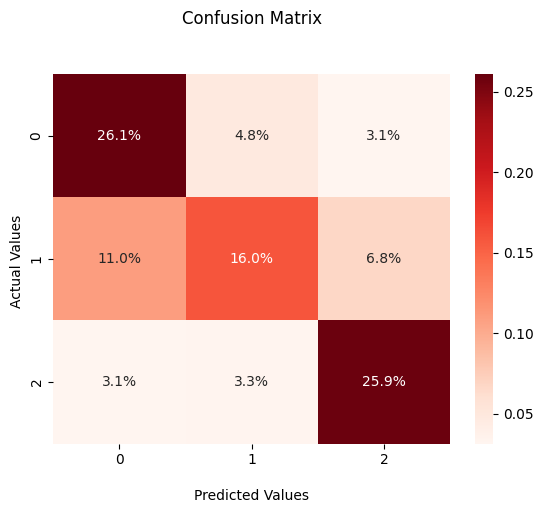

SUBJECT 20
7/7 [==============================] - 0s 11ms/step - loss: 2.0094 - accuracy: 0.4069
Score : loss of 2.0093581676483154; accuracy of 40.68571329116821%
28/28 [==============================] - 1s 5ms/step
F1 score:  0.3282857551002662
Precision:  0.41357767874024254
Recall:  0.40685714285714286


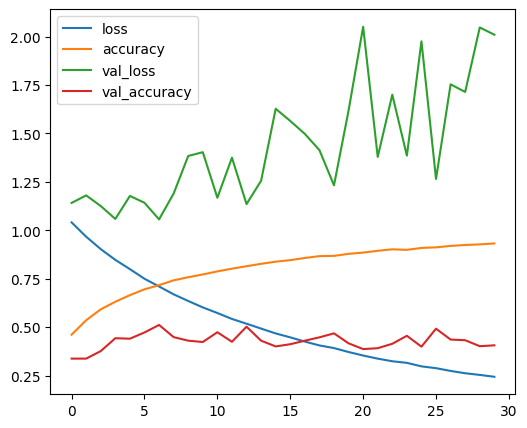

[[274   7  15]
 [186  58  43]
 [228  40  24]]


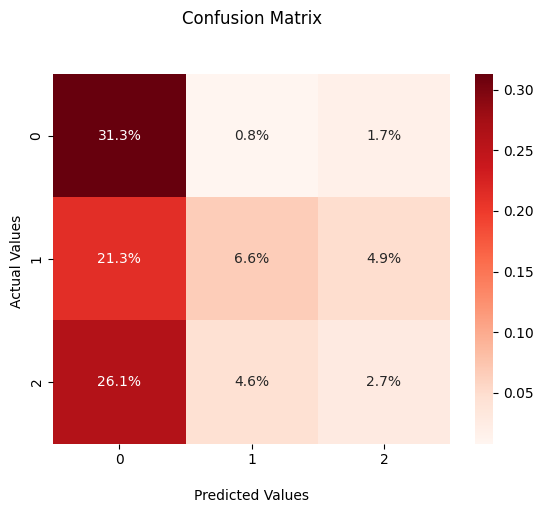

SUBJECT 21
7/7 [==============================] - 0s 11ms/step - loss: 1.2720 - accuracy: 0.4028
Score : loss of 1.2719879150390625; accuracy of 40.27939438819885%
27/27 [==============================] - 1s 5ms/step
F1 score:  0.39424356562672425
Precision:  0.41480800260698464
Recall:  0.40279394644935973


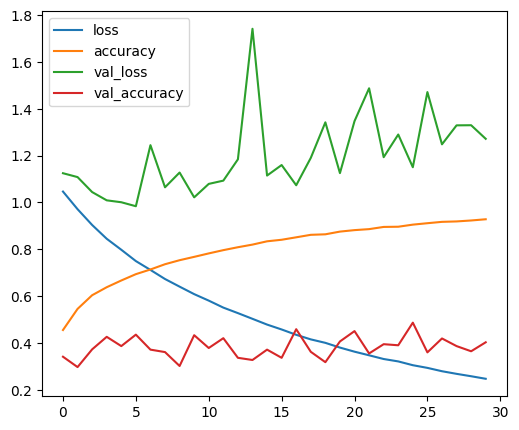

[[123 171   1]
 [ 25 159 103]
 [ 96 117  64]]


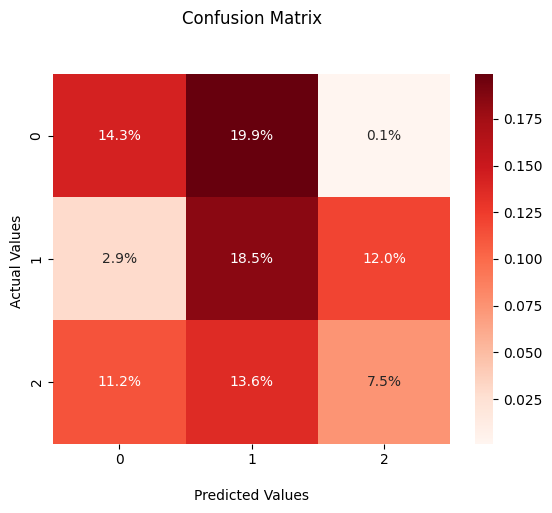

In [ ]:
from sklearn.model_selection import train_test_split


for sub in range(len(all_data)):
    print('SUBJECT',sub)

    test_data_all = all_data[sub]

    X_train_split, X_test_split, y_train_split, y_test_split = {}, {}, {}, {}

    for feature in all_features: 

      X_train_split[feature], X_test_split[feature], y_train_split[feature], y_test_split[feature] = train_test_split(test_data_all[feature], test_data_all['label'], test_size=0.05, random_state=3456789)

    
    train_data, train_data_all = {}, {}
    test_data = {}


    train_data_all["acc_x"] = np.concatenate([all_data[i]["acc_x"] for i in range(len(all_data)) if i != sub])
    train_data_all["acc_y"] = np.concatenate([all_data[i]["acc_y"] for i in range(len(all_data)) if i != sub])
    train_data_all["acc_z"] = np.concatenate([all_data[i]["acc_z"] for i in range(len(all_data)) if i != sub])
    train_data_all["eda"] = np.concatenate([all_data[i]["eda"] for i in range(len(all_data)) if i != sub])
    train_data_all["temp"] = np.concatenate([all_data[i]["temp"] for i in range(len(all_data)) if i != sub])
    train_data_all["bvp"] = np.concatenate([all_data[i]["bvp"] for i in range(len(all_data)) if i != sub])


    for feature in all_features:
      train_data[feature] = np.concatenate((train_data_all[feature], X_test_split[feature]), axis=0)


    train_data_all["label"] = np.concatenate([all_data[i]["label"] for i in range(len(all_data)) if i != sub])

    train_data["label"] = np.concatenate((train_data_all["label"], y_test_split['eda']), axis=0)

    for feature in all_features:
      test_data[feature] = X_train_split[feature]

    test_data['label'] = y_train_split['eda']

    cm_w_ft_5, acc_w_ft_5, loss_w_ft_5, f1_w_ft_5, prec_w_ft_5, rec_w_ft_5 = FCN(train_data, test_data)

#**Average accuracy and F1 score (5% ft)**

In [3]:
print(acc_w_ft_5)

[51.60183310508728, 49.43310618400574, 40.70695638656616, 52.40274667739868, 34.562212228775024, 49.01960790157318, 50.45558214187622, 46.91075384616852, 40.61032831668854, 41.081702709198, 31.284302473068237, 56.636154651641846, 53.944313526153564, 44.26605403423309, 44.29530203342438, 56.96055889129639, 45.96132040023804, 59.86471176147461, 49.09090995788574, 67.94871687889099, 40.68571329116821, 40.27939438819885]


In [11]:
print(np.mean(acc_w_ft_5))
print(np.mean(f1_w_ft_5))

47.63646735386415
0.4331419359464149


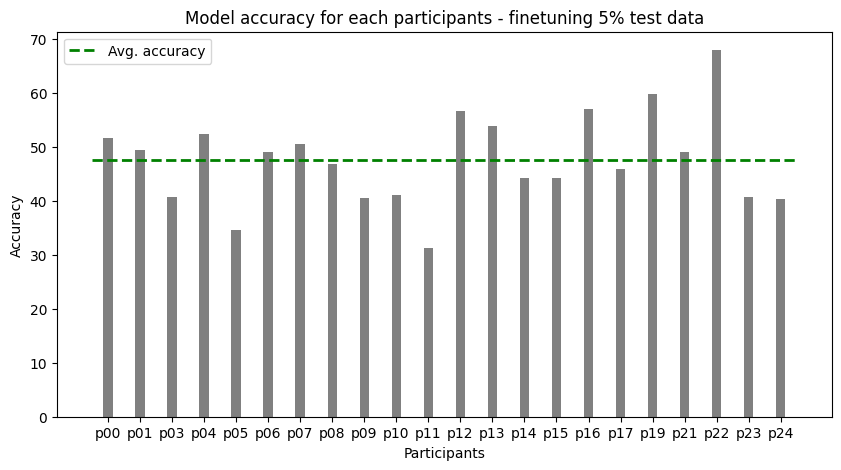

In [10]:
fig = plt.figure(figsize = (10, 5))
 
plt.bar(participants, acc_w_ft_5, color ='grey',width = 0.3)
 
plt.xlabel("Participants")
plt.ylabel("Accuracy")
plt.title("Model accuracy for each participants - finetuning 5% test data")

plt.hlines(y=(np.mean(acc_w_ft_5)), xmin=-0.5, xmax=(len(acc_w_ft_5)-0.5), colors='green', linestyles='--', lw=2, label='Avg. accuracy')
plt.legend()

plt.show()

#**Finetuning 10% of test data (LOSO)**

7/7 [==============================] - 0s 16ms/step - loss: 0.7765 - accuracy: 0.6413
Score : loss of 0.7765350341796875; accuracy of 64.13043737411499%
26/26 [==============================] - 1s 5ms/step
F1 score:  0.6344076189834752
Precision:  0.6469934564701808
Recall:  0.6413043478260869


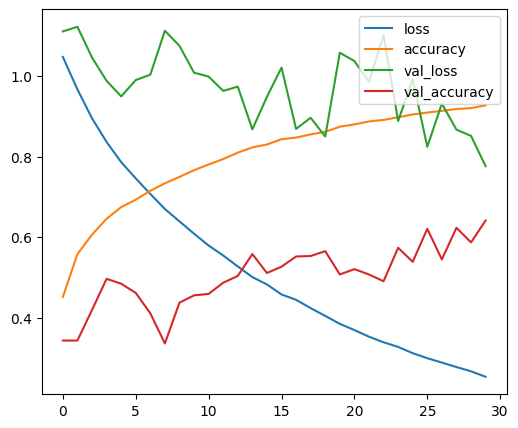

[[222  35  27]
 [139 122  24]
 [ 21  51 187]]


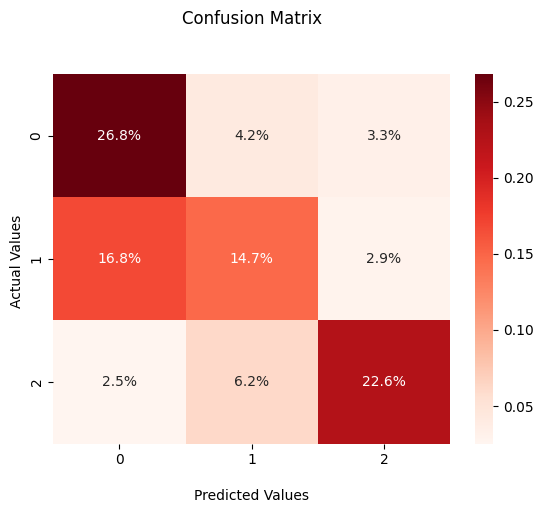

7/7 [==============================] - 0s 15ms/step - loss: 1.0847 - accuracy: 0.5550
Score : loss of 1.0847373008728027; accuracy of 55.50239086151123%
27/27 [==============================] - 1s 5ms/step
F1 score:  0.5239604823205377
Precision:  0.6475888212280149
Recall:  0.5550239234449761


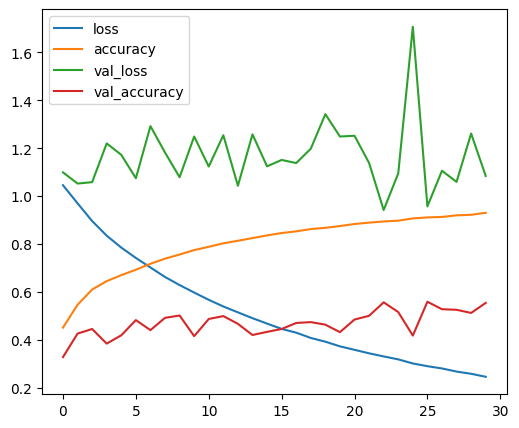

[[ 61 117  97]
 [  5 211  69]
 [  2  82 192]]


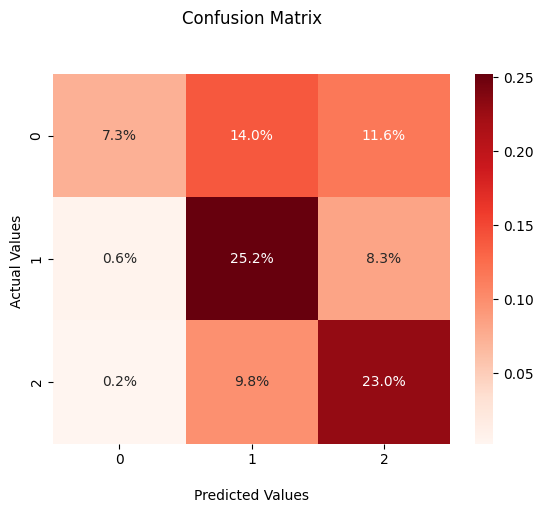

7/7 [==============================] - 0s 14ms/step - loss: 1.0449 - accuracy: 0.5295
Score : loss of 1.0449258089065552; accuracy of 52.948254346847534%
26/26 [==============================] - 1s 5ms/step
F1 score:  0.5106216364849363
Precision:  0.5355238968168791
Recall:  0.529482551143201


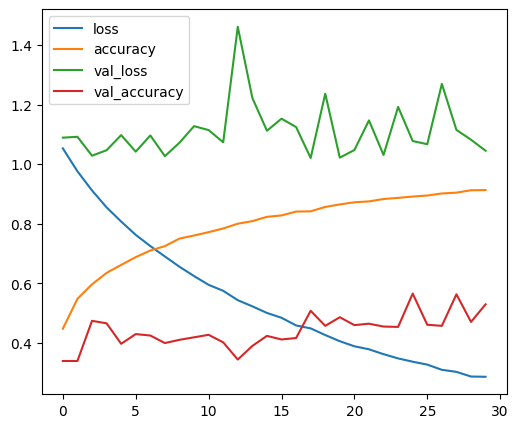

[[239  41   2]
 [115 105  54]
 [ 57 122  96]]


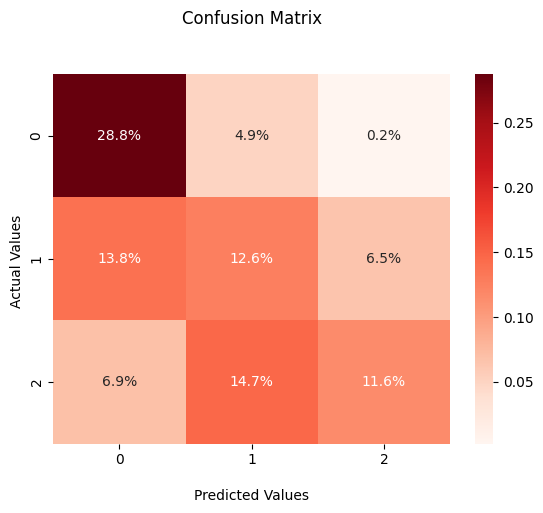

7/7 [==============================] - 0s 15ms/step - loss: 1.3749 - accuracy: 0.5048
Score : loss of 1.3749001026153564; accuracy of 50.48308968544006%
26/26 [==============================] - 1s 5ms/step
F1 score:  0.45928268786789994
Precision:  0.6720318182768776
Recall:  0.5048309178743962


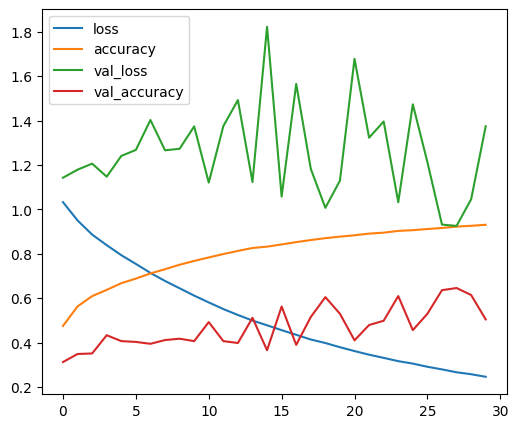

[[255   0   4]
 [182 113   1]
 [168  55  50]]


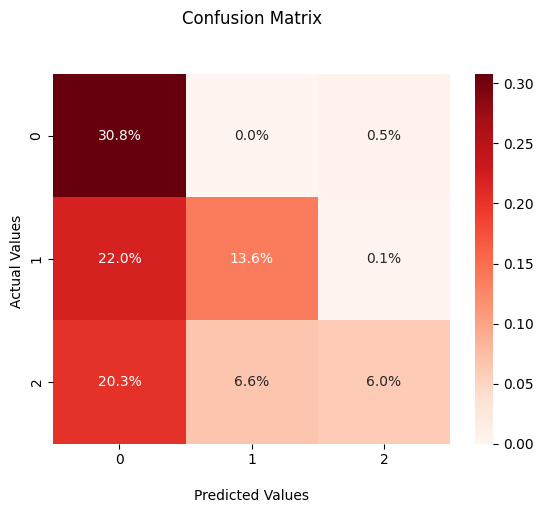

7/7 [==============================] - 0s 14ms/step - loss: 1.0862 - accuracy: 0.4562
Score : loss of 1.0862245559692383; accuracy of 45.62043845653534%
26/26 [==============================] - 1s 5ms/step
F1 score:  0.4340323411604906
Precision:  0.4301410546592955
Recall:  0.4562043795620438


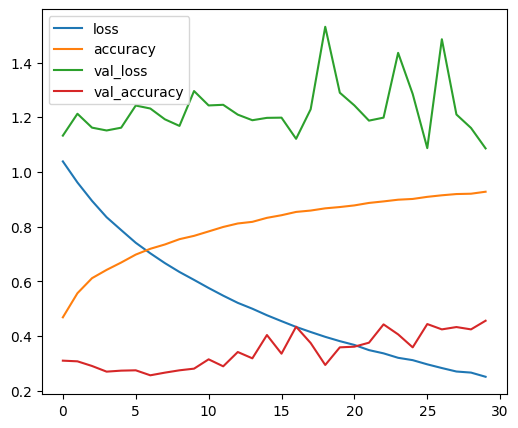

[[151  56  62]
 [ 39 179  60]
 [ 81 149  45]]


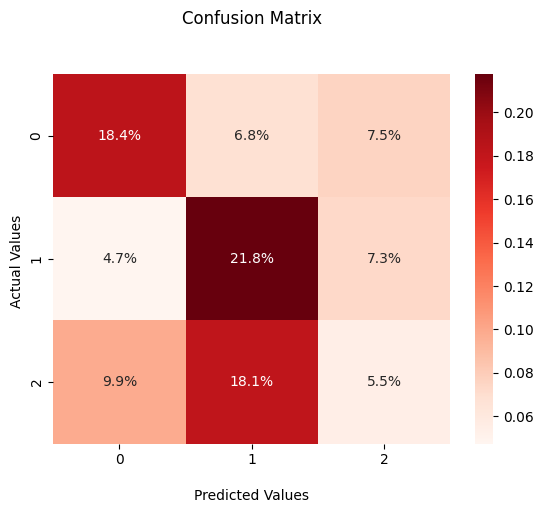

7/7 [==============================] - 0s 14ms/step - loss: 0.6867 - accuracy: 0.7016
Score : loss of 0.686659038066864; accuracy of 70.15834450721741%
26/26 [==============================] - 1s 6ms/step
F1 score:  0.693027673725404
Precision:  0.7038851942567816
Recall:  0.7015834348355664


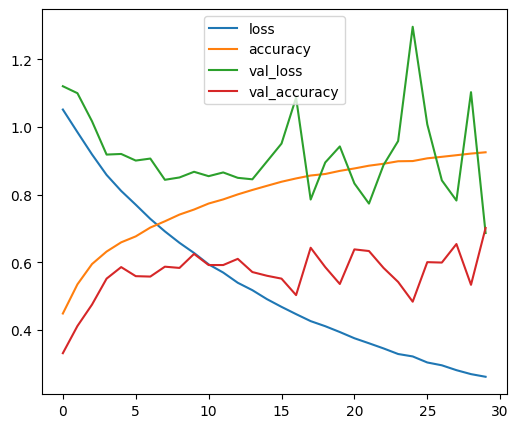

[[232   7  33]
 [ 69 137  70]
 [ 20  46 207]]


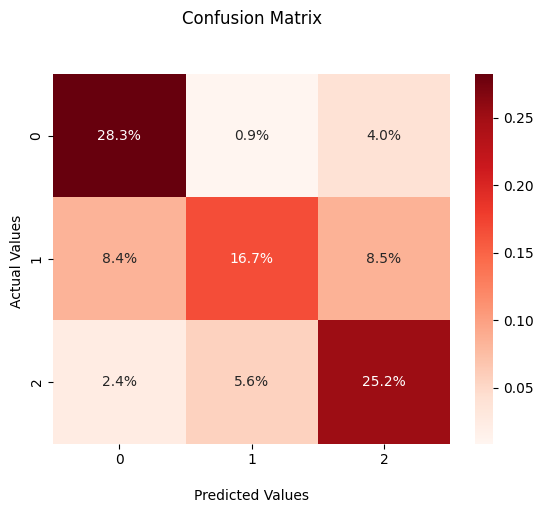

7/7 [==============================] - 0s 15ms/step - loss: 1.3357 - accuracy: 0.4435
Score : loss of 1.3357213735580444; accuracy of 44.35096085071564%
26/26 [==============================] - 1s 5ms/step
F1 score:  0.3543385993633923
Precision:  0.41205055698045007
Recall:  0.44350961538461536


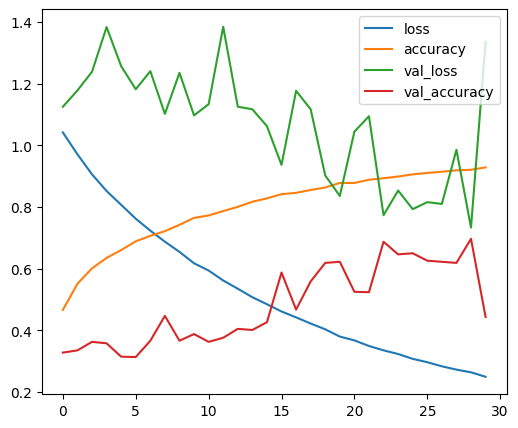

[[255  18   0]
 [160 108  15]
 [191  79   6]]


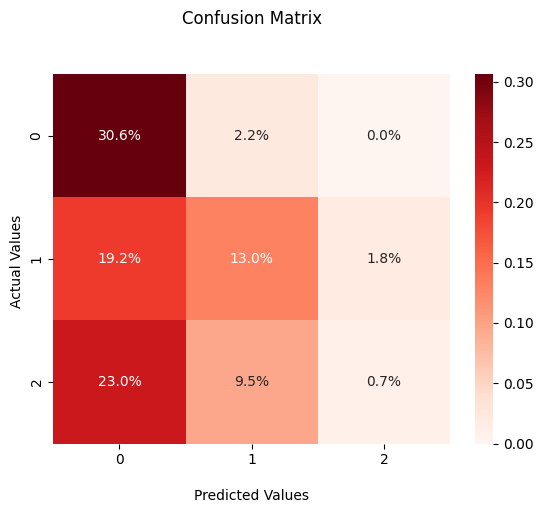

7/7 [==============================] - 0s 15ms/step - loss: 1.2718 - accuracy: 0.4179
Score : loss of 1.2718486785888672; accuracy of 41.787439584732056%
26/26 [==============================] - 1s 5ms/step
F1 score:  0.4091443610100614
Precision:  0.4336004515186092
Recall:  0.4178743961352657


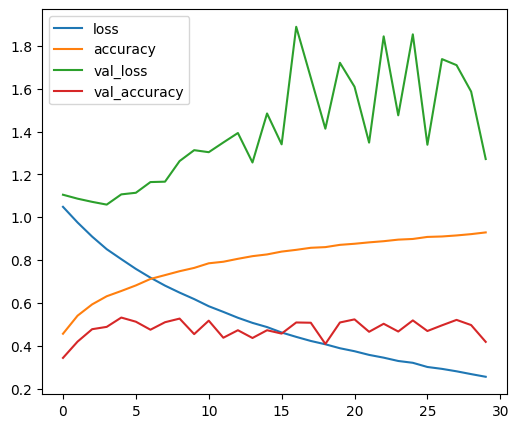

[[119  51 114]
 [ 70  60 146]
 [  5  96 167]]


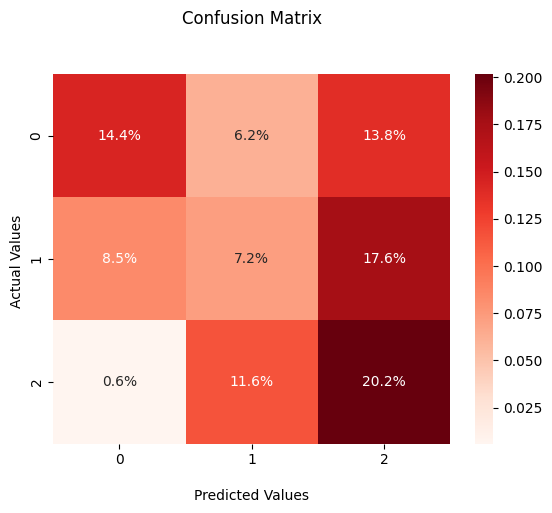

7/7 [==============================] - 0s 14ms/step - loss: 1.2287 - accuracy: 0.4746
Score : loss of 1.2286932468414307; accuracy of 47.45972752571106%
26/26 [==============================] - 1s 5ms/step
F1 score:  0.46597492385102746
Precision:  0.5815482624493356
Recall:  0.4745972738537794


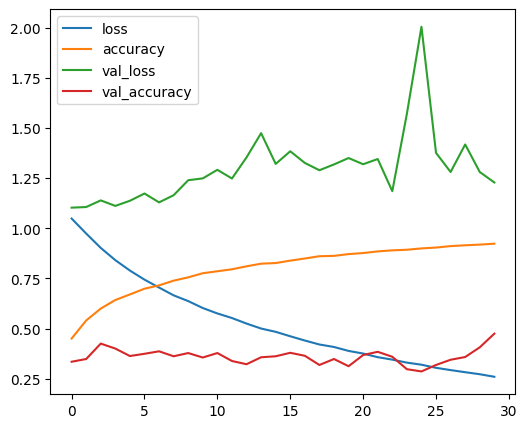

[[ 92  41 137]
 [ 14  95 171]
 [  0  61 196]]


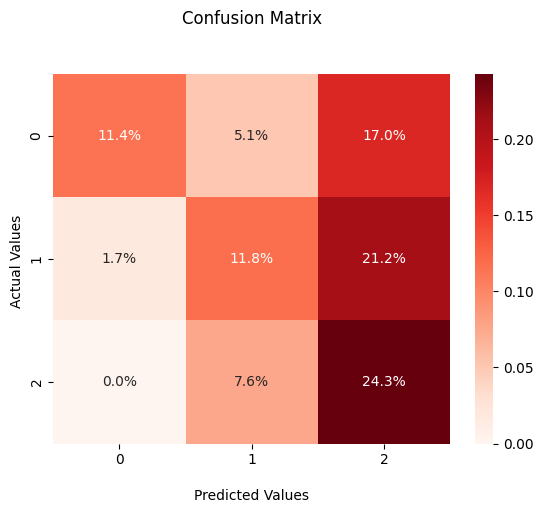

7/7 [==============================] - 0s 14ms/step - loss: 2.0893 - accuracy: 0.4107
Score : loss of 2.0892858505249023; accuracy of 41.069260239601135%
26/26 [==============================] - 1s 6ms/step
F1 score:  0.346240109863535
Precision:  0.44816666270104705
Recall:  0.4106925880923451


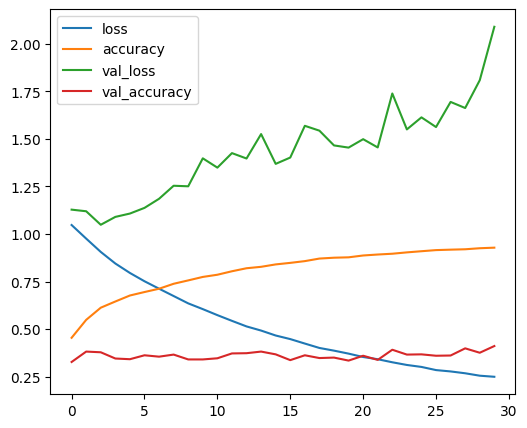

[[239  29   1]
 [172  79  41]
 [224  18  20]]


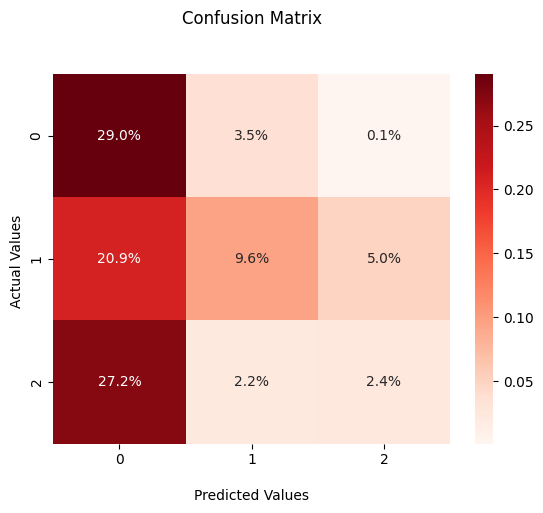

7/7 [==============================] - 0s 15ms/step - loss: 1.3302 - accuracy: 0.4994
Score : loss of 1.3302497863769531; accuracy of 49.94206130504608%
27/27 [==============================] - 1s 5ms/step
F1 score:  0.4949238831716673
Precision:  0.4986579228389462
Recall:  0.49942062572421786


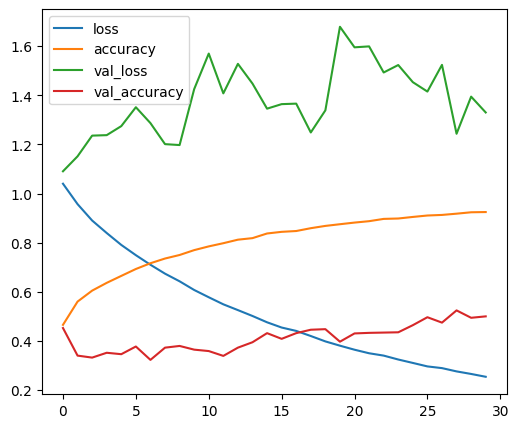

[[184  61  44]
 [ 65 117 113]
 [ 98  51 130]]


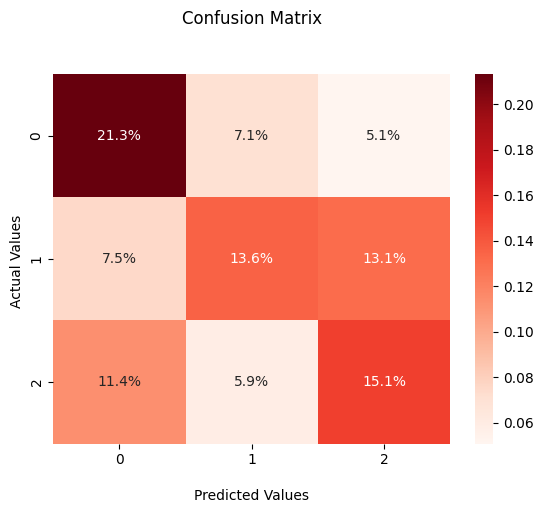

7/7 [==============================] - 0s 16ms/step - loss: 0.9475 - accuracy: 0.6159
Score : loss of 0.9474785327911377; accuracy of 61.594200134277344%
26/26 [==============================] - 2s 6ms/step
F1 score:  0.5590987870930954
Precision:  0.6113229013107944
Recall:  0.6159420289855072


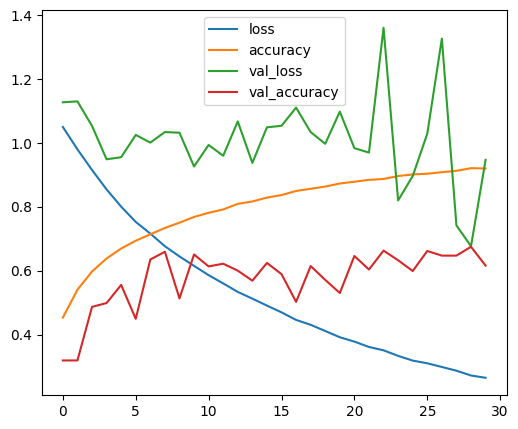

[[211  12  41]
 [ 96  48 146]
 [  0  23 251]]


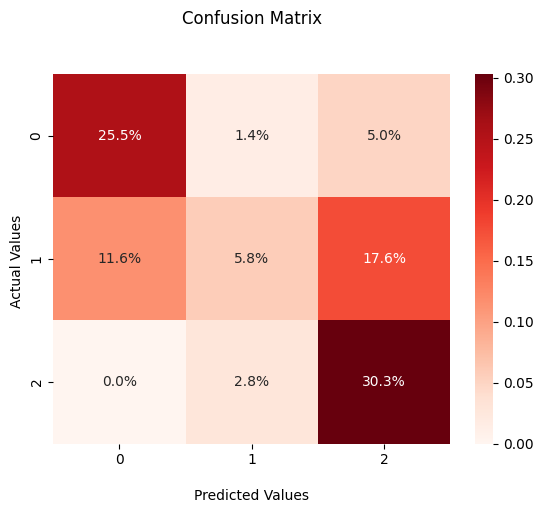

7/7 [==============================] - 0s 15ms/step - loss: 1.0011 - accuracy: 0.6218
Score : loss of 1.0011076927185059; accuracy of 62.17870116233826%
26/26 [==============================] - 1s 6ms/step
F1 score:  0.6037778192790398
Precision:  0.6562868675476362
Recall:  0.6217870257037944


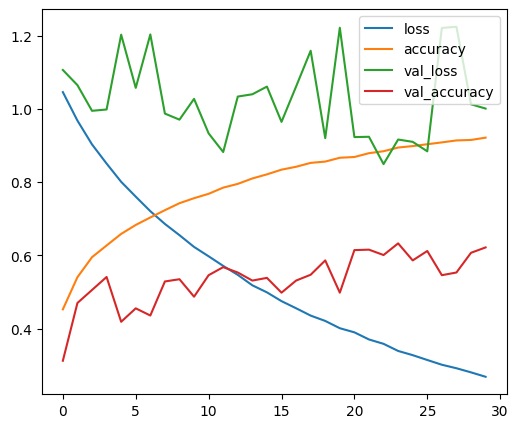

[[235   1  19]
 [158  93  28]
 [ 50  53 180]]


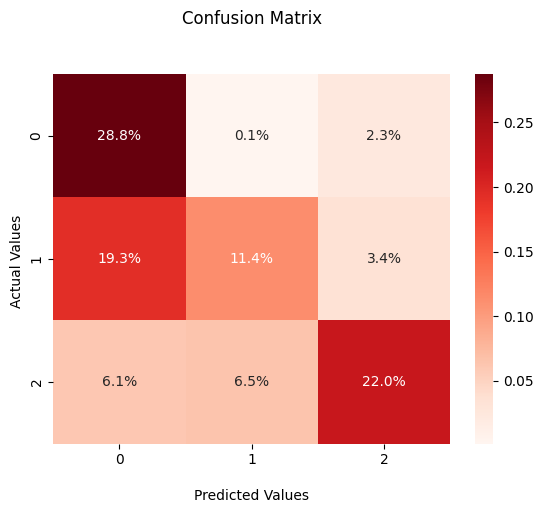

7/7 [==============================] - 0s 15ms/step - loss: 1.5549 - accuracy: 0.3729
Score : loss of 1.5549108982086182; accuracy of 37.288135290145874%
26/26 [==============================] - 1s 5ms/step
F1 score:  0.37956243752728736
Precision:  0.40380029705837067
Recall:  0.3728813559322034


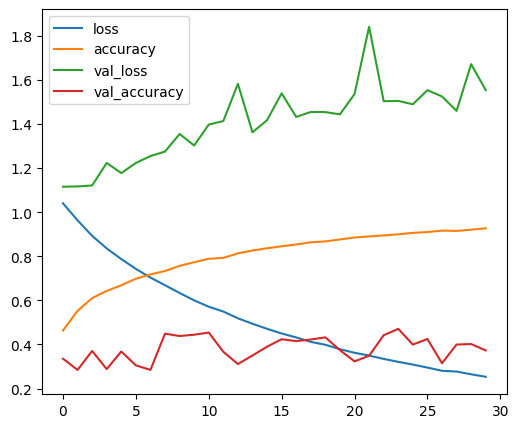

[[120  49 108]
 [ 10  87 183]
 [112  56 101]]


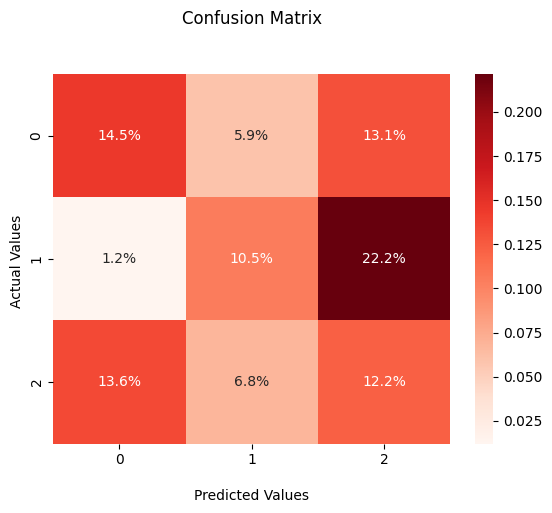

7/7 [==============================] - 0s 15ms/step - loss: 1.3755 - accuracy: 0.5466
Score : loss of 1.3755306005477905; accuracy of 54.66352105140686%
27/27 [==============================] - 1s 6ms/step
F1 score:  0.496440917220138
Precision:  0.4986401798626464
Recall:  0.5466351829988194


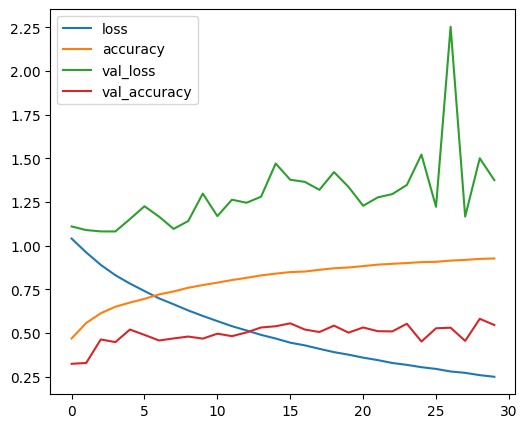

[[236  15  19]
 [218  25  42]
 [ 16  74 202]]


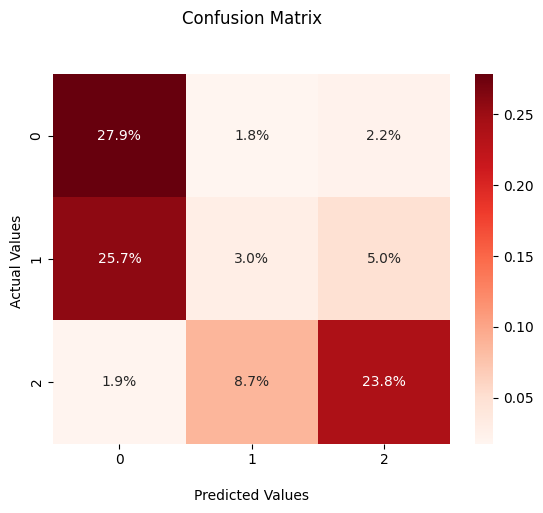

7/7 [==============================] - 0s 14ms/step - loss: 0.9805 - accuracy: 0.5496
Score : loss of 0.9804959893226624; accuracy of 54.957157373428345%
26/26 [==============================] - 1s 6ms/step
F1 score:  0.532596145493067
Precision:  0.5849561365902562
Recall:  0.5495716034271726


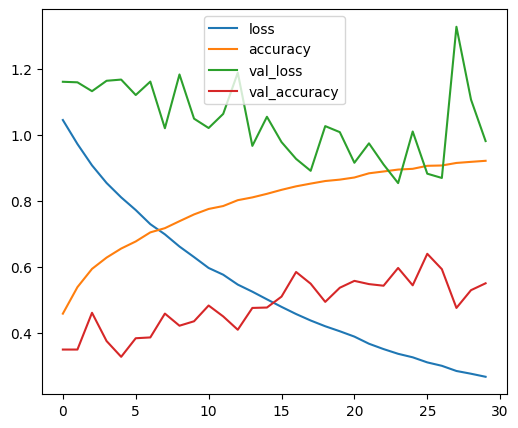

[[111  45 129]
 [ 55 112 106]
 [ 25   8 226]]


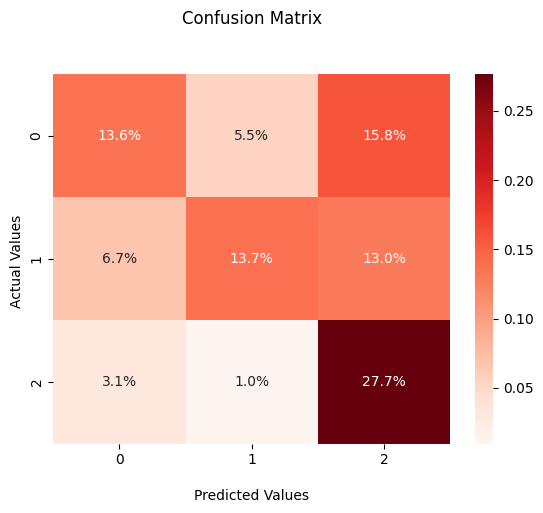

7/7 [==============================] - 0s 15ms/step - loss: 0.9294 - accuracy: 0.6411
Score : loss of 0.929367184638977; accuracy of 64.10564184188843%
27/27 [==============================] - 1s 6ms/step
F1 score:  0.6269979493036291
Precision:  0.6957319879452936
Recall:  0.6410564225690276


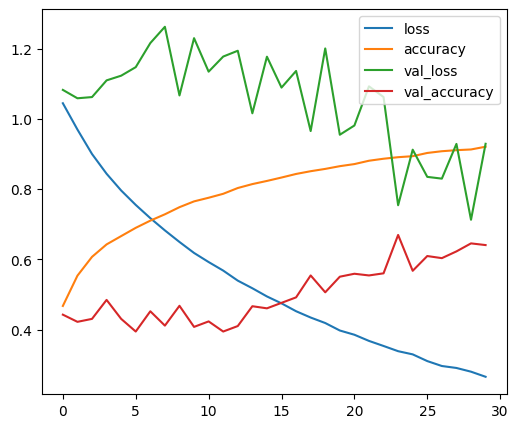

[[195  23  71]
 [ 47 105 128]
 [ 30   0 234]]


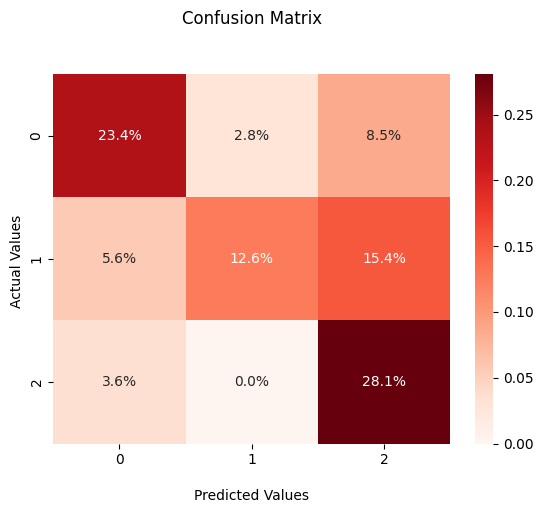

7/7 [==============================] - 0s 15ms/step - loss: 1.0144 - accuracy: 0.6190
Score : loss of 1.014379620552063; accuracy of 61.90476417541504%
27/27 [==============================] - 1s 6ms/step
F1 score:  0.5853686771244022
Precision:  0.684165345414938
Recall:  0.6190476190476191


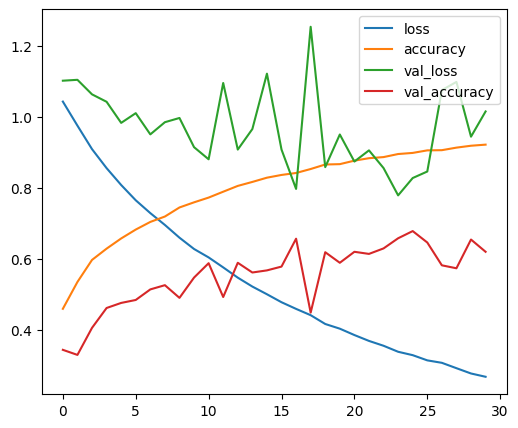

[[ 75 104 109]
 [  6 225  51]
 [  6  44 220]]


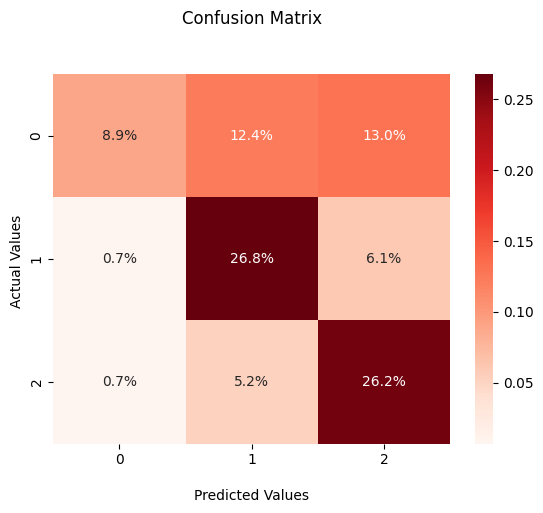

7/7 [==============================] - 0s 16ms/step - loss: 1.0073 - accuracy: 0.5791
Score : loss of 1.0073444843292236; accuracy of 57.91366696357727%
27/27 [==============================] - 1s 6ms/step
F1 score:  0.5737728893065048
Precision:  0.5810890110915958
Recall:  0.579136690647482


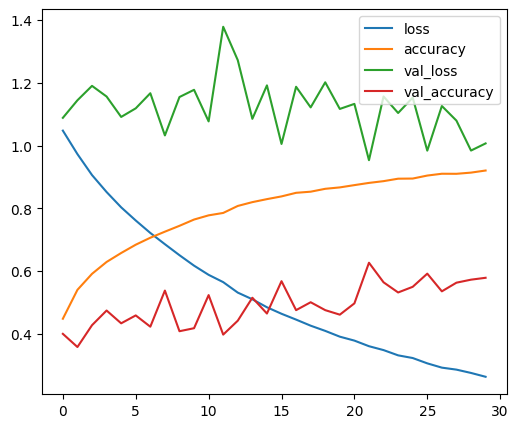

[[123  93  70]
 [ 29 186  65]
 [ 55  39 174]]


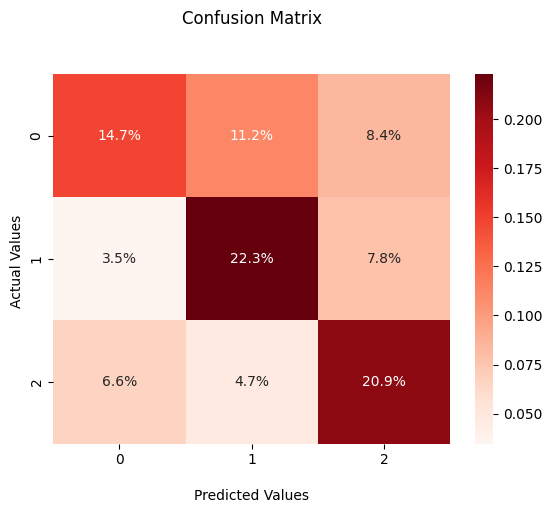

7/7 [==============================] - 0s 16ms/step - loss: 0.8566 - accuracy: 0.6507
Score : loss of 0.8565930128097534; accuracy of 65.06764888763428%
26/26 [==============================] - 1s 5ms/step
F1 score:  0.6477427442820254
Precision:  0.6505632656519709
Recall:  0.6506765067650676


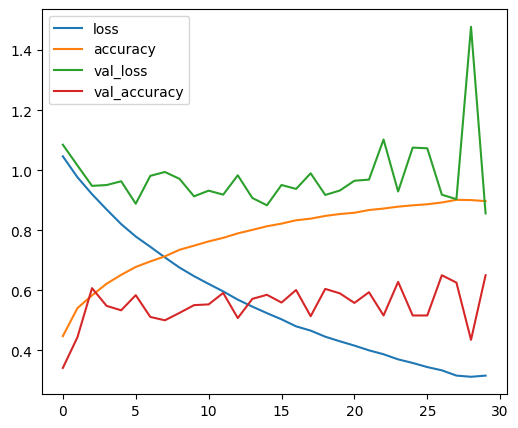

[[224  49   5]
 [ 98 129  47]
 [  5  80 176]]


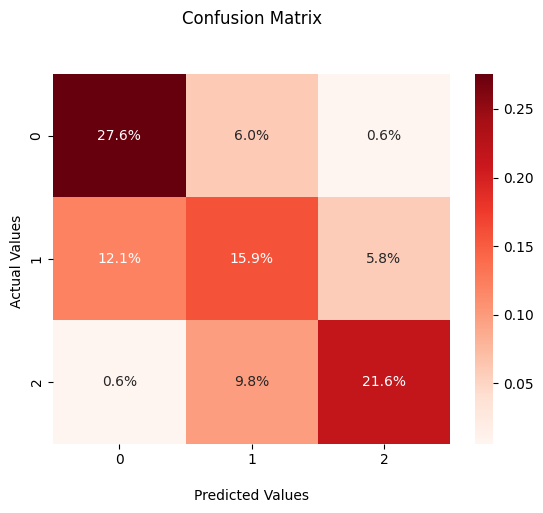

7/7 [==============================] - 0s 15ms/step - loss: 1.6283 - accuracy: 0.4958
Score : loss of 1.6282832622528076; accuracy of 49.577805399894714%
26/26 [==============================] - 2s 6ms/step
F1 score:  0.4333452464842195
Precision:  0.5969974471018114
Recall:  0.4957780458383595


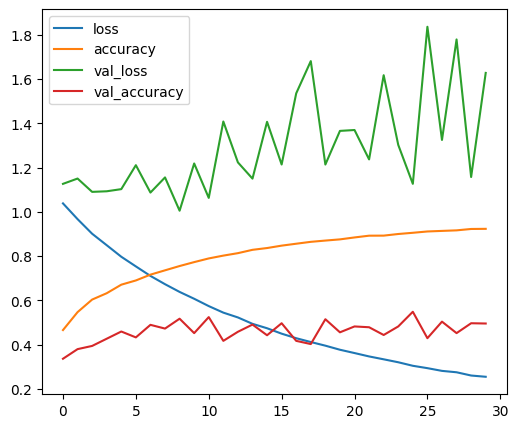

[[258  21   0]
 [132 127  12]
 [215  38  26]]


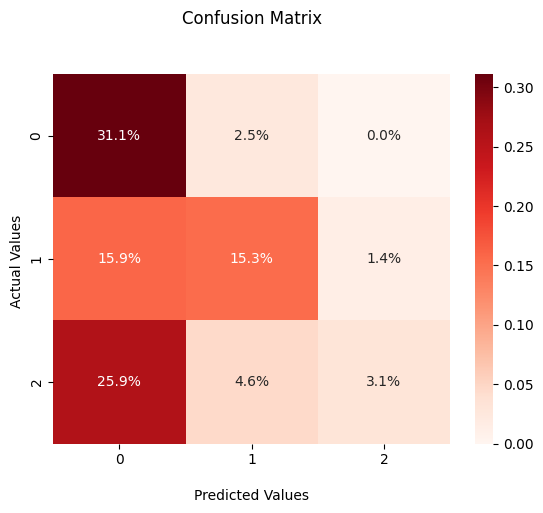

7/7 [==============================] - 0s 15ms/step - loss: 1.1198 - accuracy: 0.4668
Score : loss of 1.1198248863220215; accuracy of 46.68304622173309%
26/26 [==============================] - 1s 6ms/step
F1 score:  0.4585195914526961
Precision:  0.46297317017451867
Recall:  0.4668304668304668


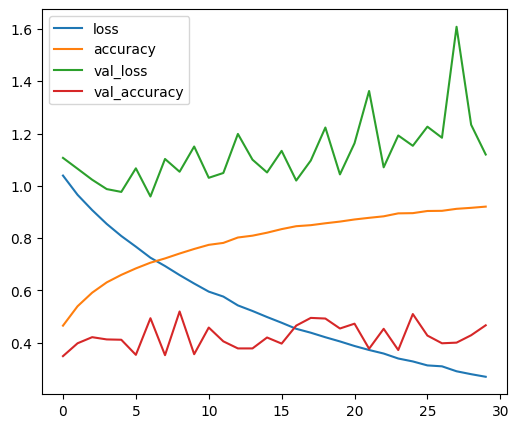

[[175 108   1]
 [ 49 129  95]
 [108  73  76]]


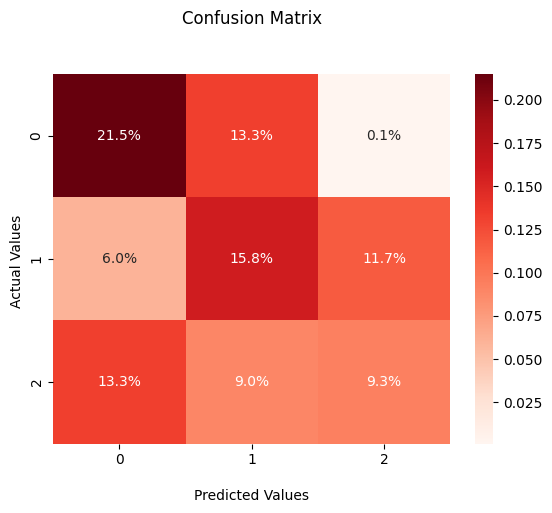

In [ ]:
from sklearn.model_selection import train_test_split


for sub in range(len(all_data)):

    test_data_all = all_data[sub]

    X_train_split, X_test_split, y_train_split, y_test_split = {}, {}, {}, {}

    for feature in all_features: 

      X_train_split[feature], X_test_split[feature], y_train_split[feature], y_test_split[feature] = train_test_split(test_data_all[feature], test_data_all['label'], test_size=0.1, random_state=3456789)

    
    train_data, train_data_all = {}, {}
    test_data = {}


    train_data_all["acc_x"] = np.concatenate([all_data[i]["acc_x"] for i in range(len(all_data)) if i != sub])
    train_data_all["acc_y"] = np.concatenate([all_data[i]["acc_y"] for i in range(len(all_data)) if i != sub])
    train_data_all["acc_z"] = np.concatenate([all_data[i]["acc_z"] for i in range(len(all_data)) if i != sub])
    train_data_all["eda"] = np.concatenate([all_data[i]["eda"] for i in range(len(all_data)) if i != sub])
    train_data_all["temp"] = np.concatenate([all_data[i]["temp"] for i in range(len(all_data)) if i != sub])
    train_data_all["bvp"] = np.concatenate([all_data[i]["bvp"] for i in range(len(all_data)) if i != sub])


    for feature in all_features:
      train_data[feature] = np.concatenate((train_data_all[feature], X_test_split[feature]), axis=0)


    train_data_all["label"] = np.concatenate([all_data[i]["label"] for i in range(len(all_data)) if i != sub])

    train_data["label"] = np.concatenate((train_data_all["label"], y_test_split['eda']), axis=0)

    for feature in all_features:
      test_data[feature] = X_train_split[feature]

    test_data['label'] = y_train_split['eda']

    cm_w_ft_10, acc_w_ft_10, loss_w_ft_10, f1_w_ft_10, prec_w_ft_10, rec_w_ft_10 = FCN(train_data, test_data)

#**Average accuracy and F1 score (10% ft)**

In [13]:
print(acc_w_ft_10)

[64.13043737411499, 55.50239086151123, 52.948254346847534, 50.48308968544006, 45.62043845653534, 70.15834450721741, 44.35096085071564, 41.787439584732056, 47.45972752571106, 41.069260239601135, 49.94206130504608, 61.594200134277344, 62.17870116233826, 37.288135290145874, 54.66352105140686, 54.957157373428345, 64.10564184188843, 61.90476417541504, 57.91366696357727, 65.06764888763428, 49.577805399894714, 46.68304622173309]


In [14]:
print(np.mean(acc_w_ft_10))
print(np.mean(f1_w_ft_10))

53.80848605632782
0.5434931204633769


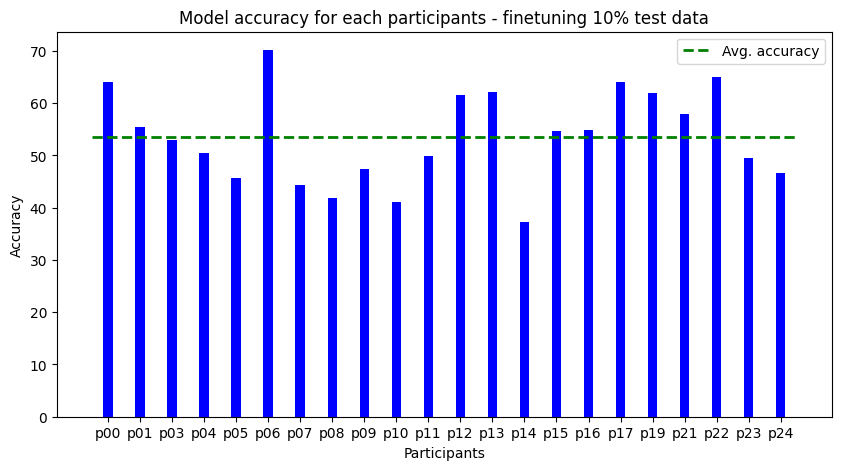

In [ ]:
fig = plt.figure(figsize = (10, 5))
 
plt.bar(participants, acc_w_ft_10, color ='blue',width = 0.3)
 
plt.xlabel("Participants")
plt.ylabel("Accuracy")
plt.title("Model accuracy for each participants - finetuning 10% test data")

plt.hlines(y=(np.mean(acc_w_ft_10)), xmin=-0.5, xmax=(len(f1_w_ft_10)-0.5), colors='green', linestyles='--', lw=2, label='Avg. accuracy')
plt.legend()

plt.show()

#**Finetuning 20% of test data (LOSO)**

6/6 [==============================] - 0s 16ms/step - loss: 0.6884 - accuracy: 0.6997
Score : loss of 0.6883813738822937; accuracy of 69.972825050354%
23/23 [==============================] - 1s 6ms/step
F1 score:  0.7004002141163718
Precision:  0.7026256863804122
Recall:  0.6997282608695652


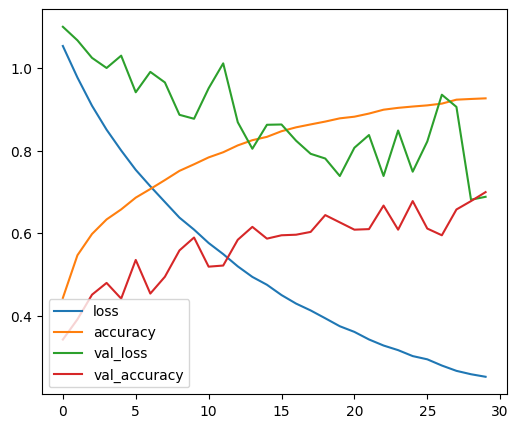

[[177  50  25]
 [ 86 153  12]
 [ 13  35 185]]


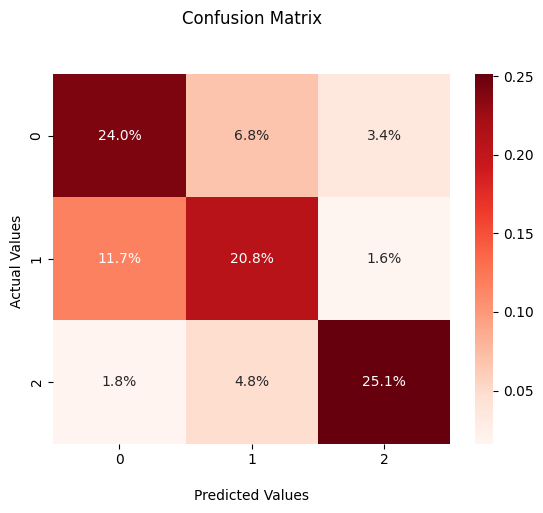

6/6 [==============================] - 0s 15ms/step - loss: 0.8137 - accuracy: 0.6649
Score : loss of 0.8137304186820984; accuracy of 66.48721694946289%
24/24 [==============================] - 1s 6ms/step
F1 score:  0.6614229301955281
Precision:  0.6840507547196002
Recall:  0.6648721399730821


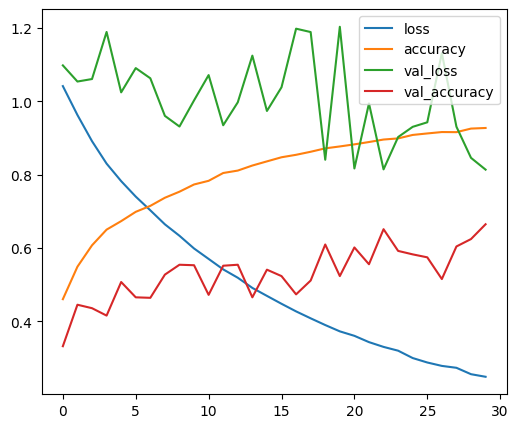

[[132  54  61]
 [ 32 202  12]
 [  8  82 160]]


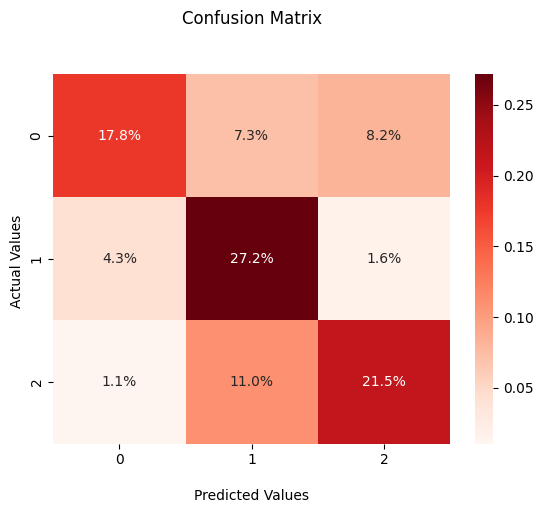

6/6 [==============================] - 0s 15ms/step - loss: 0.9627 - accuracy: 0.5562
Score : loss of 0.9626612067222595; accuracy of 55.61569929122925%
24/24 [==============================] - 1s 6ms/step
F1 score:  0.5385489317170596
Precision:  0.5968782764188184
Recall:  0.5561569688768606


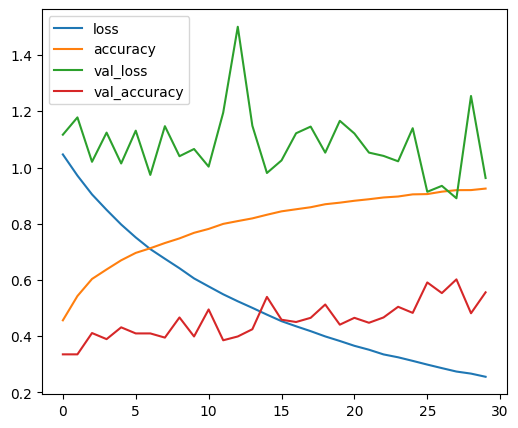

[[211  37   0]
 [ 90 120  27]
 [ 40 134  80]]


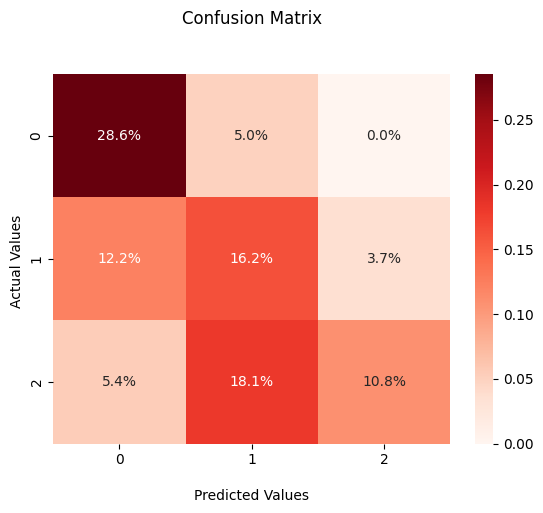

6/6 [==============================] - 0s 15ms/step - loss: 1.1541 - accuracy: 0.5408
Score : loss of 1.154146432876587; accuracy of 54.076087474823%
23/23 [==============================] - 1s 6ms/step
F1 score:  0.5192280446915539
Precision:  0.7963960789680841
Recall:  0.5407608695652174


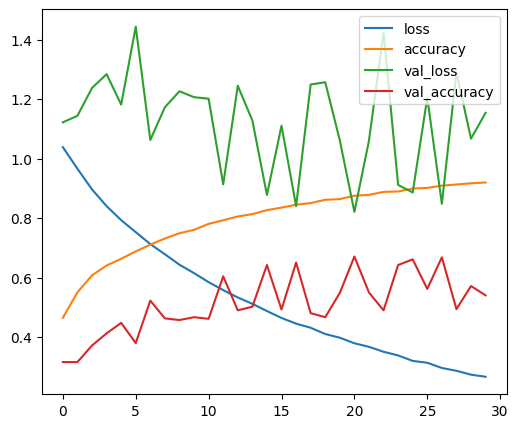

[[233   0   0]
 [184  76   1]
 [150   3  89]]


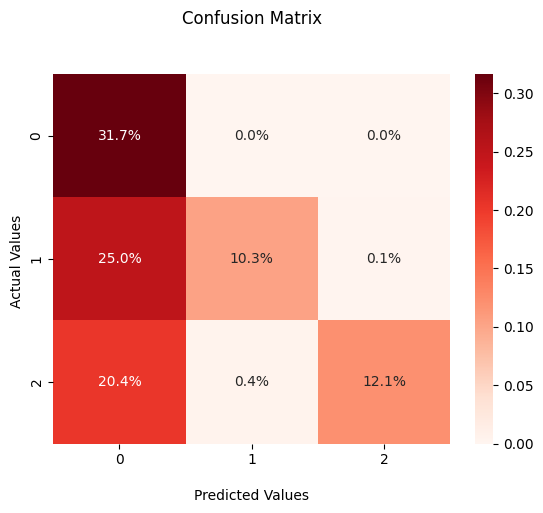

6/6 [==============================] - 0s 17ms/step - loss: 0.9181 - accuracy: 0.5308
Score : loss of 0.9180612564086914; accuracy of 53.077977895736694%
23/23 [==============================] - 1s 6ms/step
F1 score:  0.49659831689614947
Precision:  0.5285241810056003
Recall:  0.53077975376197


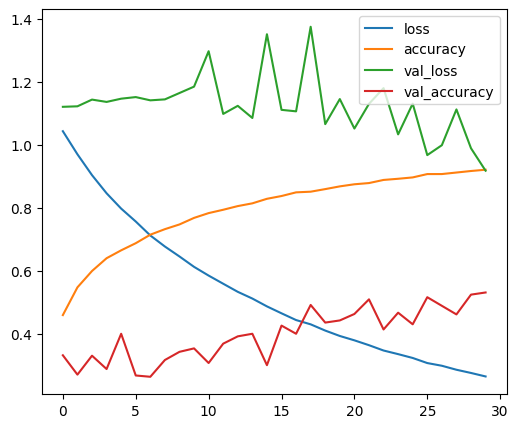

[[168  57  17]
 [ 33 178  32]
 [ 51 153  42]]


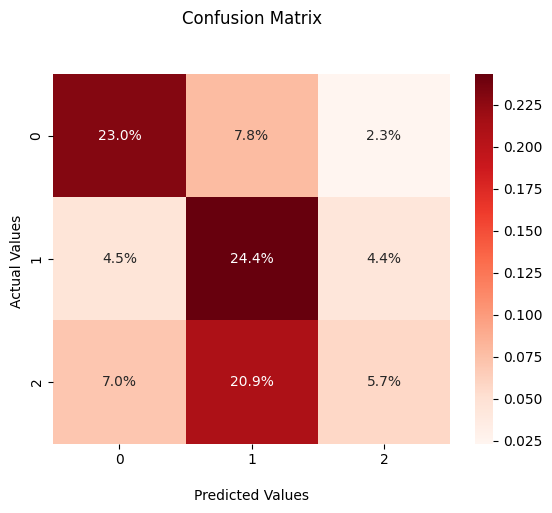

6/6 [==============================] - 0s 15ms/step - loss: 1.0470 - accuracy: 0.5438
Score : loss of 1.0470178127288818; accuracy of 54.38356399536133%
23/23 [==============================] - 1s 6ms/step
F1 score:  0.5106282807740853
Precision:  0.6919249878620203
Recall:  0.5438356164383562


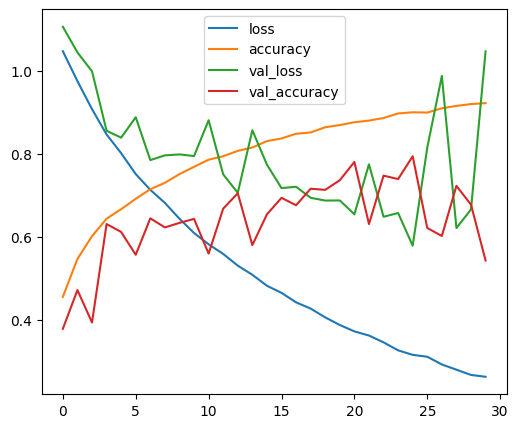

[[242   3   0]
 [160  80   1]
 [125  44  75]]


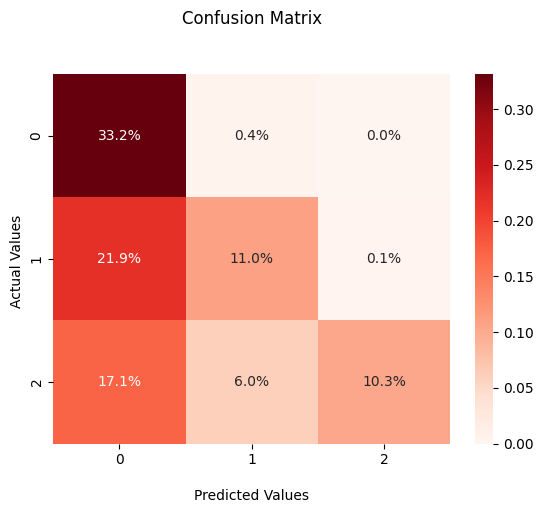

6/6 [==============================] - 0s 15ms/step - loss: 0.9453 - accuracy: 0.6176
Score : loss of 0.9453105330467224; accuracy of 61.75675392150879%
24/24 [==============================] - 1s 6ms/step
F1 score:  0.6069889537121134
Precision:  0.741109746109746
Recall:  0.6175675675675676


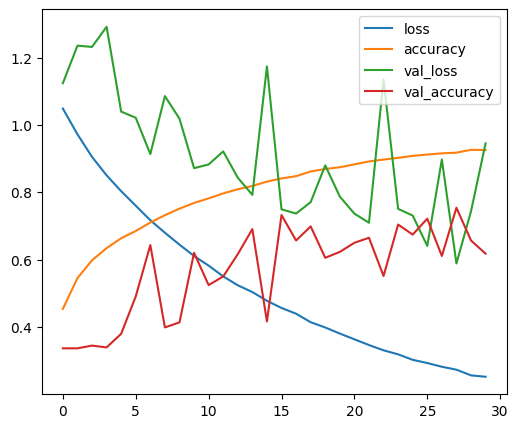

[[ 94 136  19]
 [  0 232  15]
 [  6 107 131]]


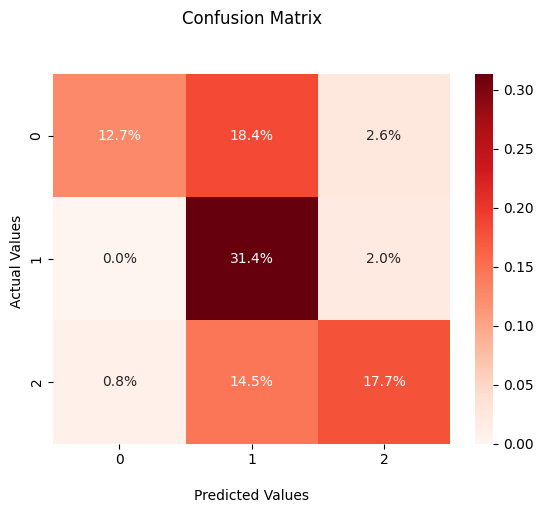

6/6 [==============================] - 0s 16ms/step - loss: 0.9849 - accuracy: 0.5543
Score : loss of 0.9849393963813782; accuracy of 55.434781312942505%
23/23 [==============================] - 1s 6ms/step
F1 score:  0.5524203759064749
Precision:  0.5508760875467777
Recall:  0.5543478260869565


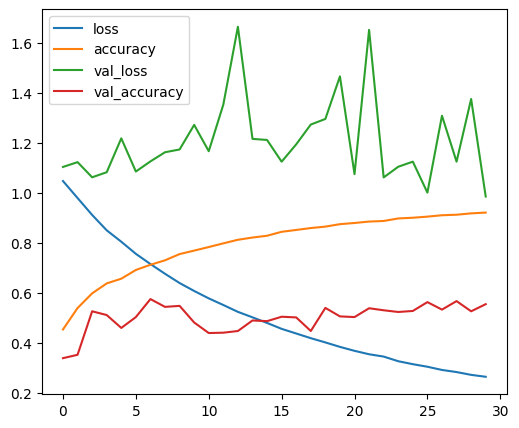

[[150  76  23]
 [ 77  97  70]
 [ 23  59 161]]


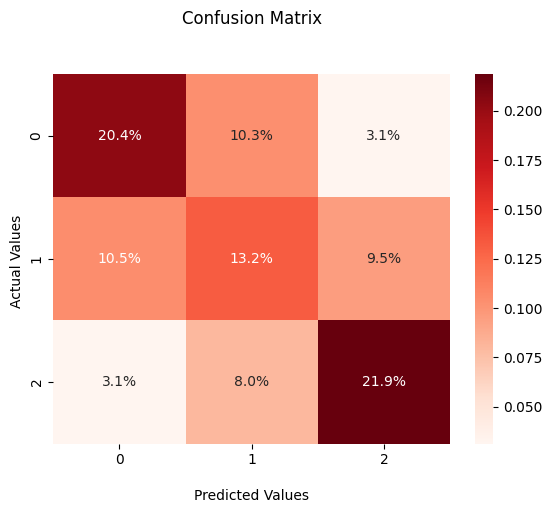

6/6 [==============================] - 0s 15ms/step - loss: 1.3655 - accuracy: 0.5202
Score : loss of 1.3655060529708862; accuracy of 52.02231407165527%
23/23 [==============================] - 1s 6ms/step
F1 score:  0.4429478583605589
Precision:  0.7862470415584225
Recall:  0.5202231520223152


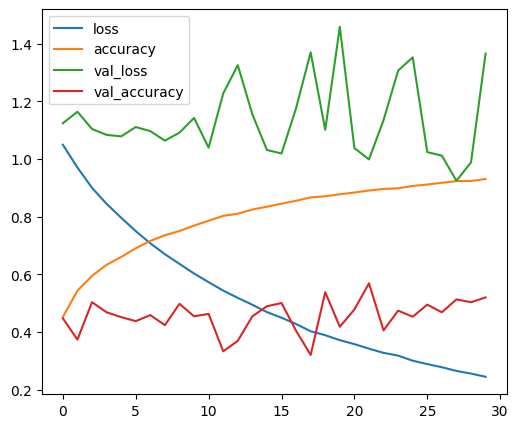

[[131   0 110]
 [  9   8 225]
 [  0   0 234]]


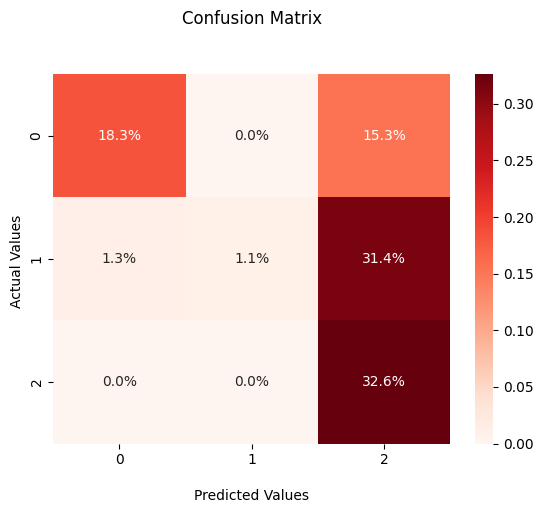

6/6 [==============================] - 0s 16ms/step - loss: 1.1727 - accuracy: 0.5697
Score : loss of 1.1727397441864014; accuracy of 56.96721076965332%
23/23 [==============================] - 1s 6ms/step
F1 score:  0.5260112049454708
Precision:  0.7038903632953943
Recall:  0.569672131147541


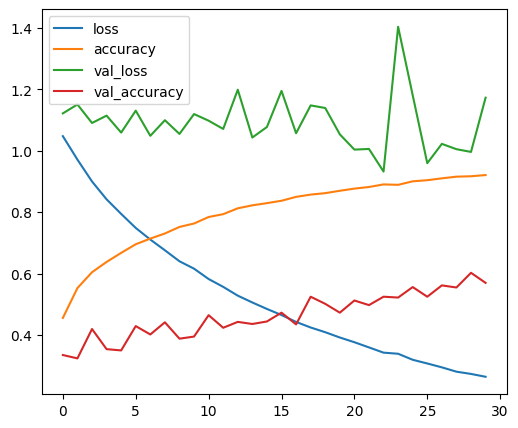

[[231  14   0]
 [104 144   3]
 [149  45  42]]


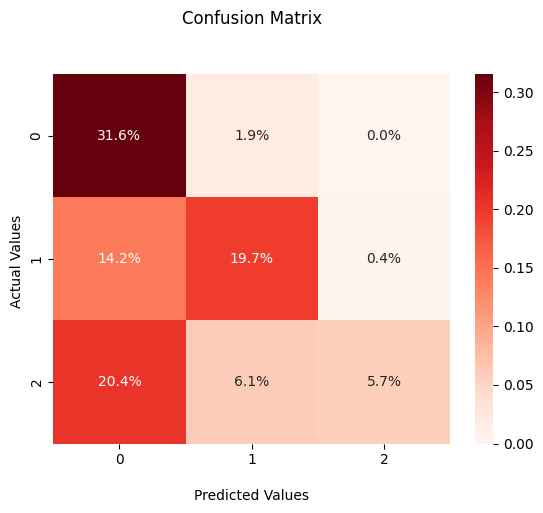

6/6 [==============================] - 0s 18ms/step - loss: 0.9605 - accuracy: 0.5906
Score : loss of 0.9605430364608765; accuracy of 59.06127691268921%
24/24 [==============================] - 1s 6ms/step
F1 score:  0.5920203869459433
Precision:  0.5952891609370449
Recall:  0.590612777053455


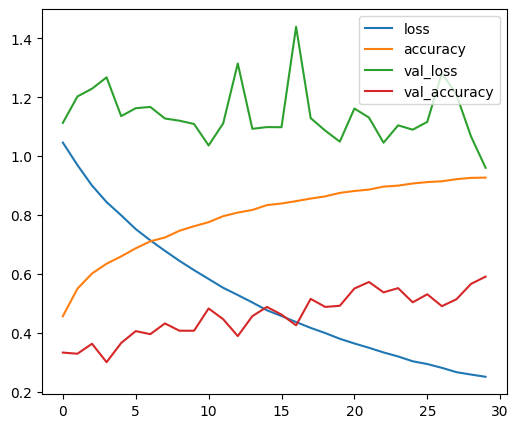

[[162  35  58]
 [ 32 157  76]
 [ 67  46 134]]


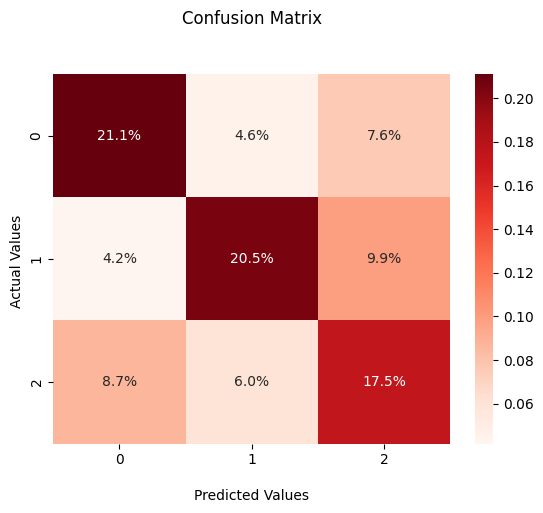

6/6 [==============================] - 0s 16ms/step - loss: 0.6336 - accuracy: 0.7242
Score : loss of 0.6335907578468323; accuracy of 72.41848111152649%
23/23 [==============================] - 1s 6ms/step
F1 score:  0.6884204814677323
Precision:  0.7340826104469249
Recall:  0.7241847826086957


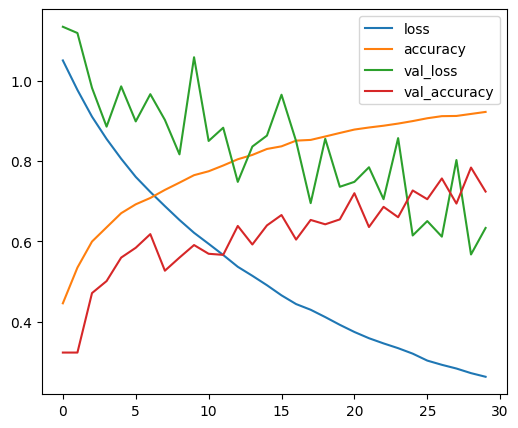

[[229   9   0]
 [112  81  62]
 [  2  18 223]]


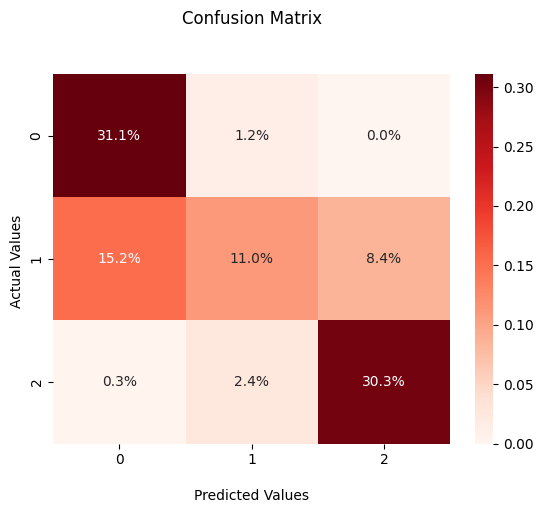

6/6 [==============================] - 0s 16ms/step - loss: 0.6350 - accuracy: 0.7163
Score : loss of 0.6350138783454895; accuracy of 71.62534594535828%
23/23 [==============================] - 1s 7ms/step
F1 score:  0.7168368506684246
Precision:  0.7294826110361697
Recall:  0.7162534435261708


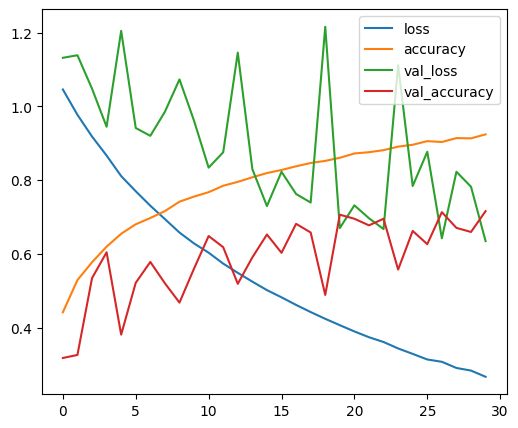

[[196  30   5]
 [ 66 157  22]
 [ 10  73 167]]


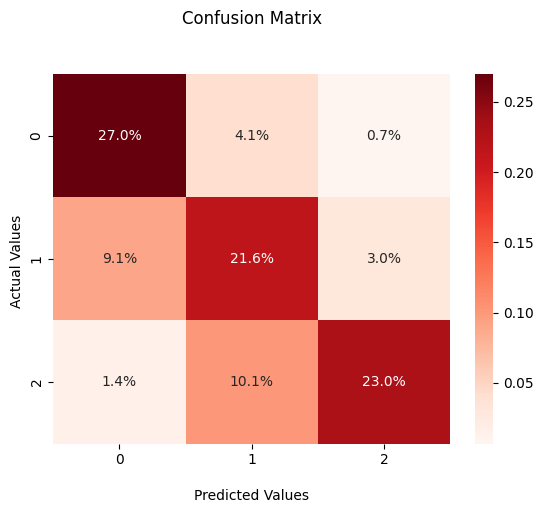

6/6 [==============================] - 0s 16ms/step - loss: 1.1802 - accuracy: 0.5123
Score : loss of 1.1801633834838867; accuracy of 51.22615694999695%
23/23 [==============================] - 1s 6ms/step
F1 score:  0.46628987114203535
Precision:  0.559776210145921
Recall:  0.5122615803814714


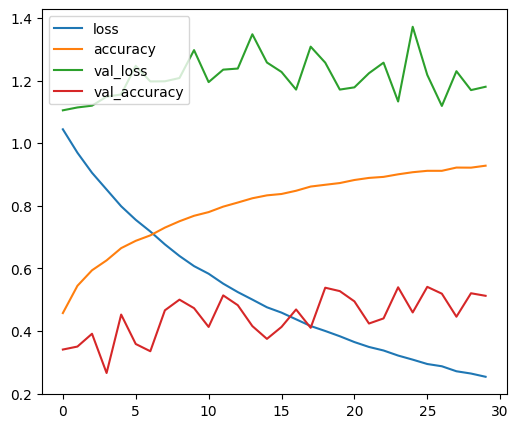

[[ 87 139  24]
 [  3 236   6]
 [ 63 123  53]]


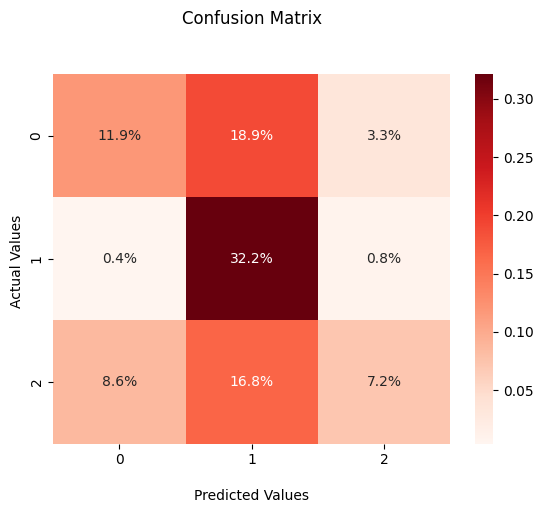

6/6 [==============================] - 0s 17ms/step - loss: 1.4630 - accuracy: 0.5007
Score : loss of 1.4630407094955444; accuracy of 50.066399574279785%
24/24 [==============================] - 1s 6ms/step
F1 score:  0.4332985275563425
Precision:  0.504713486724788
Recall:  0.50066401062417


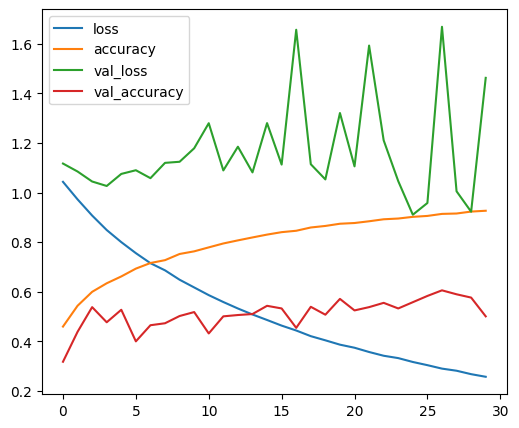

[[236   0   3]
 [243   8   6]
 [ 78  46 133]]


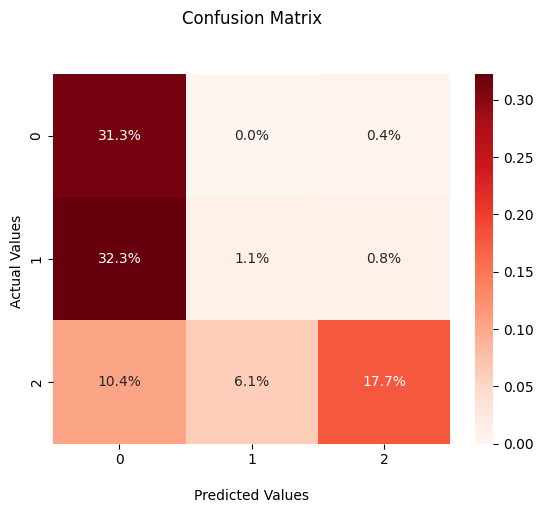

6/6 [==============================] - 0s 17ms/step - loss: 0.7296 - accuracy: 0.7039
Score : loss of 0.7296128869056702; accuracy of 70.38567662239075%
23/23 [==============================] - 1s 6ms/step
F1 score:  0.6808886609450769
Precision:  0.7704205479853271
Recall:  0.7038567493112947


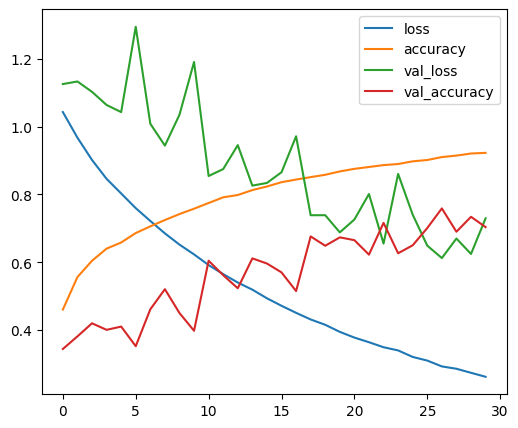

[[235   0  15]
 [124  85  33]
 [ 36   7 191]]


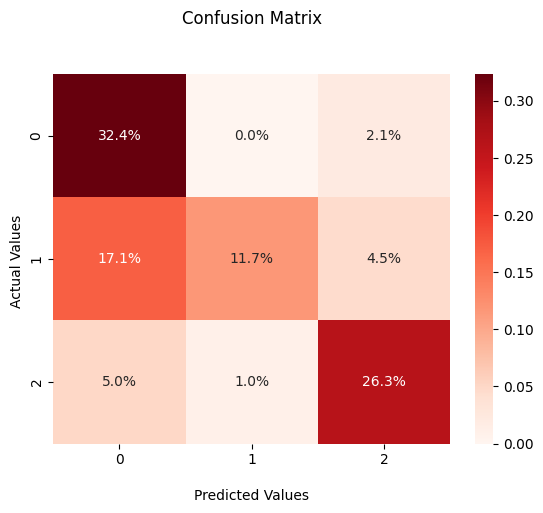

6/6 [==============================] - 0s 16ms/step - loss: 0.6872 - accuracy: 0.7149
Score : loss of 0.6871933937072754; accuracy of 71.48648500442505%
24/24 [==============================] - 1s 6ms/step
F1 score:  0.7102593166290199
Precision:  0.781967972464161
Recall:  0.7148648648648649


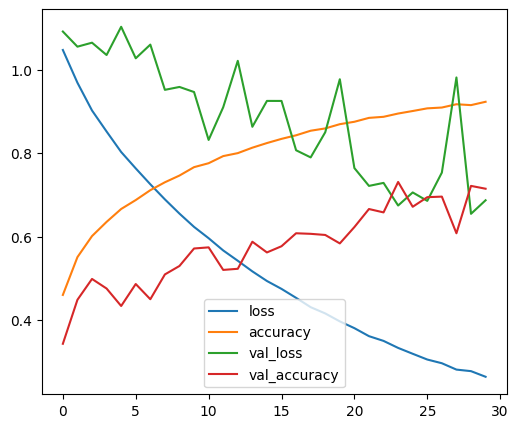

[[172  66  16]
 [  8 237   0]
 [ 15 106 120]]


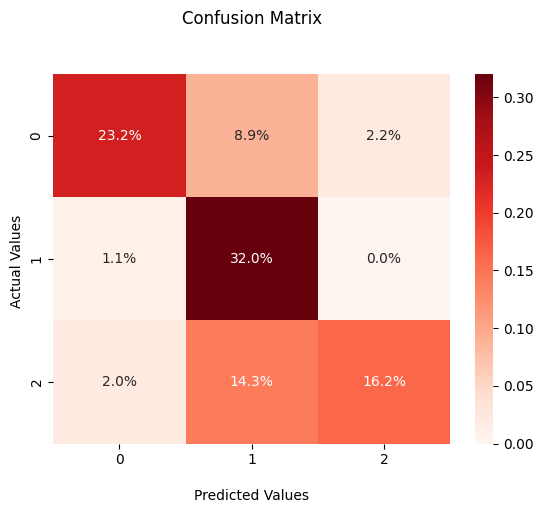

6/6 [==============================] - 0s 16ms/step - loss: 0.7525 - accuracy: 0.7269
Score : loss of 0.7525290846824646; accuracy of 72.69076108932495%
24/24 [==============================] - 1s 6ms/step
F1 score:  0.707503637766169
Precision:  0.7865173021468462
Recall:  0.7269076305220884


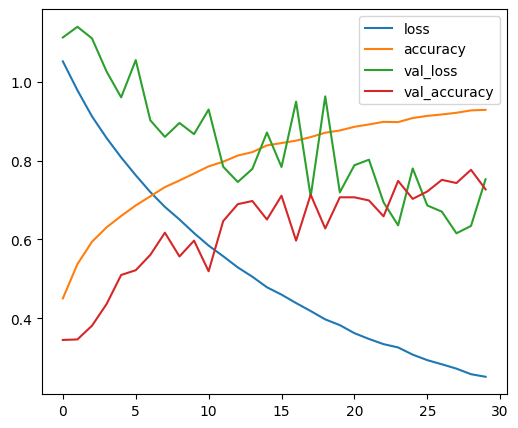

[[107  67  86]
 [  0 218  31]
 [  3  17 218]]


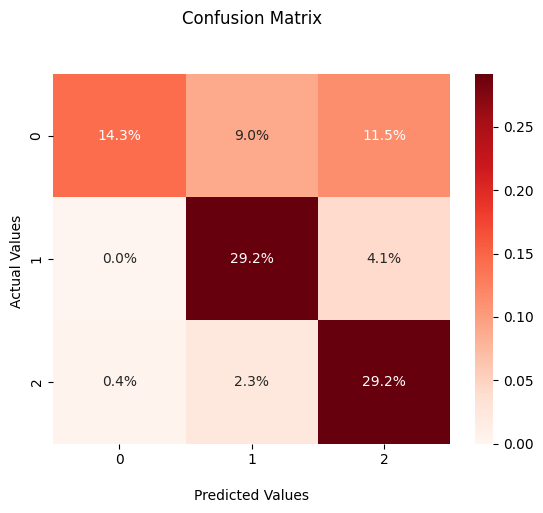

6/6 [==============================] - 0s 15ms/step - loss: 1.1910 - accuracy: 0.4993
Score : loss of 1.191023588180542; accuracy of 49.93252456188202%
24/24 [==============================] - 1s 6ms/step
F1 score:  0.463277449936147
Precision:  0.6698794865839998
Recall:  0.4993252361673414


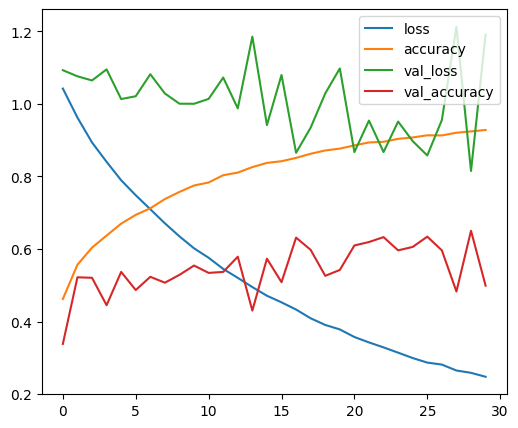

[[ 90 161   0]
 [ 17 226   2]
 [ 36 155  54]]


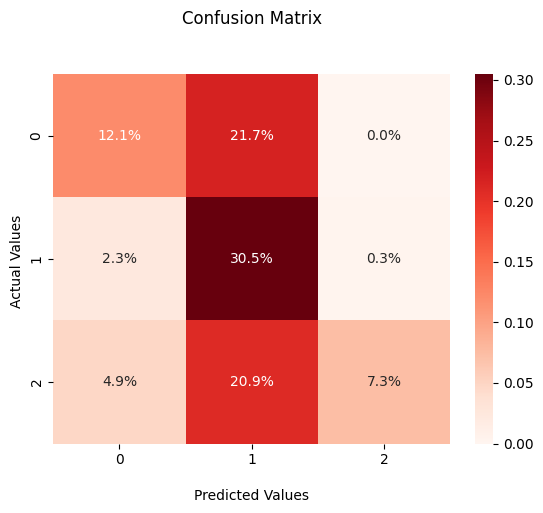

6/6 [==============================] - 0s 15ms/step - loss: 0.6899 - accuracy: 0.7220
Score : loss of 0.6899495124816895; accuracy of 72.19917178153992%
23/23 [==============================] - 1s 6ms/step
F1 score:  0.725653653242922
Precision:  0.7666650567838478
Recall:  0.7219917012448133


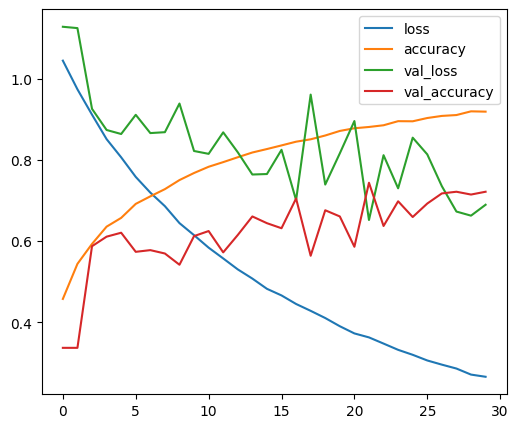

[[162  76   6]
 [ 28 207   6]
 [ 16  69 153]]


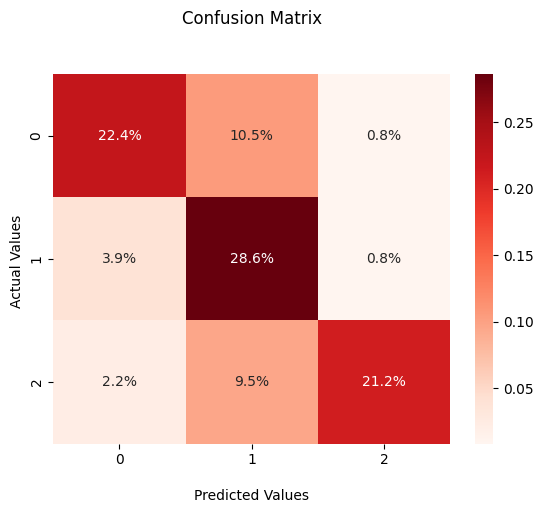

6/6 [==============================] - 0s 17ms/step - loss: 1.5747 - accuracy: 0.4993
Score : loss of 1.5746643543243408; accuracy of 49.93215799331665%
24/24 [==============================] - 1s 7ms/step
F1 score:  0.42851066996334775
Precision:  0.6714389507801044
Recall:  0.4993215739484396


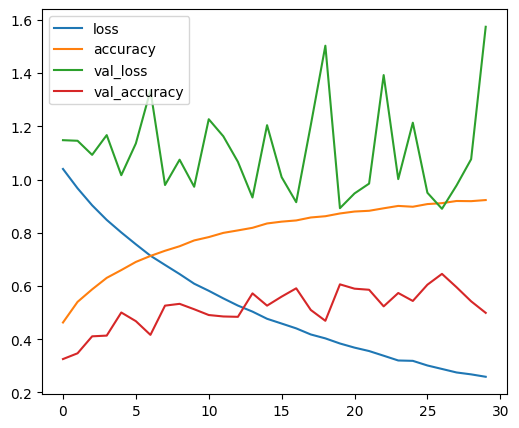

[[228   0  12]
 [142  20  77]
 [138   0 120]]


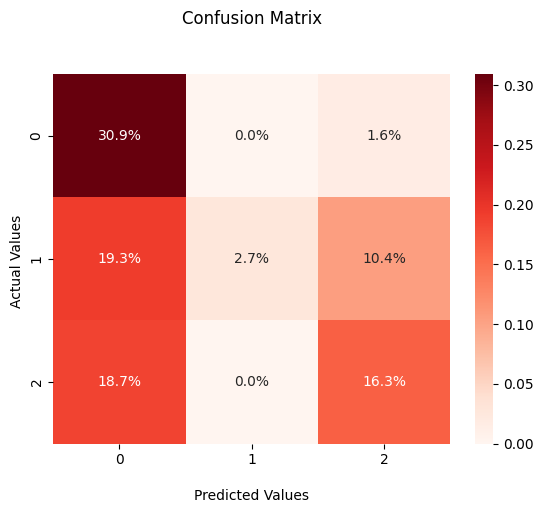

6/6 [==============================] - 0s 15ms/step - loss: 0.9317 - accuracy: 0.5290
Score : loss of 0.9317142963409424; accuracy of 52.90055274963379%
23/23 [==============================] - 1s 6ms/step
F1 score:  0.5223651604415276
Precision:  0.5615335930617907
Recall:  0.5290055248618785


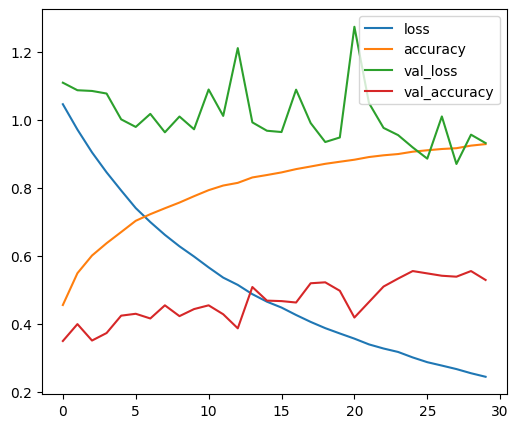

[[115 130   8]
 [  1 178  61]
 [ 59  82  90]]


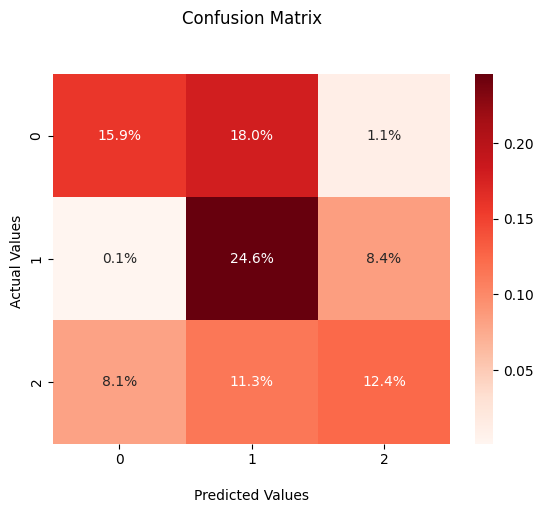

In [ ]:
from sklearn.model_selection import train_test_split


for sub in range(len(all_data)):

    test_data_all = all_data[sub]

    X_train_split, X_test_split, y_train_split, y_test_split = {}, {}, {}, {}

    for feature in all_features: 

      X_train_split[feature], X_test_split[feature], y_train_split[feature], y_test_split[feature] = train_test_split(test_data_all[feature], test_data_all['label'], test_size=0.2, random_state=3456789)

    
    train_data, train_data_all = {}, {}
    test_data = {}


    train_data_all["acc_x"] = np.concatenate([all_data[i]["acc_x"] for i in range(len(all_data)) if i != sub])
    train_data_all["acc_y"] = np.concatenate([all_data[i]["acc_y"] for i in range(len(all_data)) if i != sub])
    train_data_all["acc_z"] = np.concatenate([all_data[i]["acc_z"] for i in range(len(all_data)) if i != sub])
    train_data_all["eda"] = np.concatenate([all_data[i]["eda"] for i in range(len(all_data)) if i != sub])
    train_data_all["temp"] = np.concatenate([all_data[i]["temp"] for i in range(len(all_data)) if i != sub])
    train_data_all["bvp"] = np.concatenate([all_data[i]["bvp"] for i in range(len(all_data)) if i != sub])


    for feature in all_features:
      train_data[feature] = np.concatenate((train_data_all[feature], X_test_split[feature]), axis=0)


    train_data_all["label"] = np.concatenate([all_data[i]["label"] for i in range(len(all_data)) if i != sub])

    train_data["label"] = np.concatenate((train_data_all["label"], y_test_split['eda']), axis=0)


    for feature in all_features:
      test_data[feature] = X_train_split[feature]

    test_data['label'] = y_train_split['eda']

    cm_w_ft_20, acc_w_ft_20, loss_w_ft_20, f1_w_ft_20, prec_w_ft_20, rec_w_ft_20 = FCN(train_data, test_data)

#**Average accuracy and F1 score (20% ft)**

In [15]:
print(acc_w_ft_20)

[69.972825050354, 66.48721694946289, 55.61569929122925, 54.076087474823, 53.077977895736694, 54.38356399536133, 61.75675392150879, 55.434781312942505, 52.02231407165527, 56.96721076965332, 59.06127691268921, 72.41848111152649, 71.62534594535828, 51.22615694999695, 50.066399574279785, 70.38567662239075, 71.48648500442505, 72.69076108932495, 49.93252456188202, 72.19917178153992, 49.93215799331665, 52.90055274963379]


In [16]:
print(np.mean(acc_w_ft_20))
print(np.mean(f1_w_ft_20))

60.1690645922314
0.5768418080918208


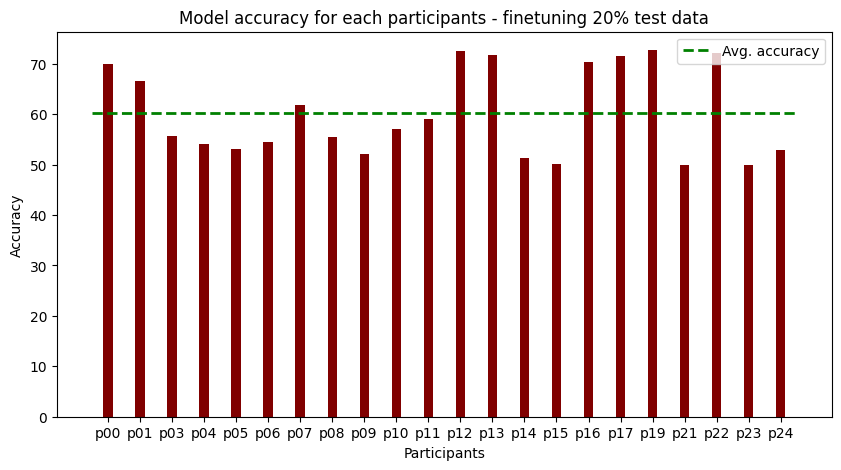

In [ ]:
fig = plt.figure(figsize = (10, 5))
 
plt.bar(participants, acc_w_ft_20, color ='maroon',width = 0.3)
 
plt.xlabel("Participants")
plt.ylabel("Accuracy")
plt.title("Model accuracy for each participants - finetuning 20% test data")

plt.hlines(y=(np.mean(acc_w_ft_20)), xmin=-0.5, xmax=(len(f1_w_ft_20)-0.5), colors='green', linestyles='--', lw=2, label='Avg. accuracy')
plt.legend()

plt.show()

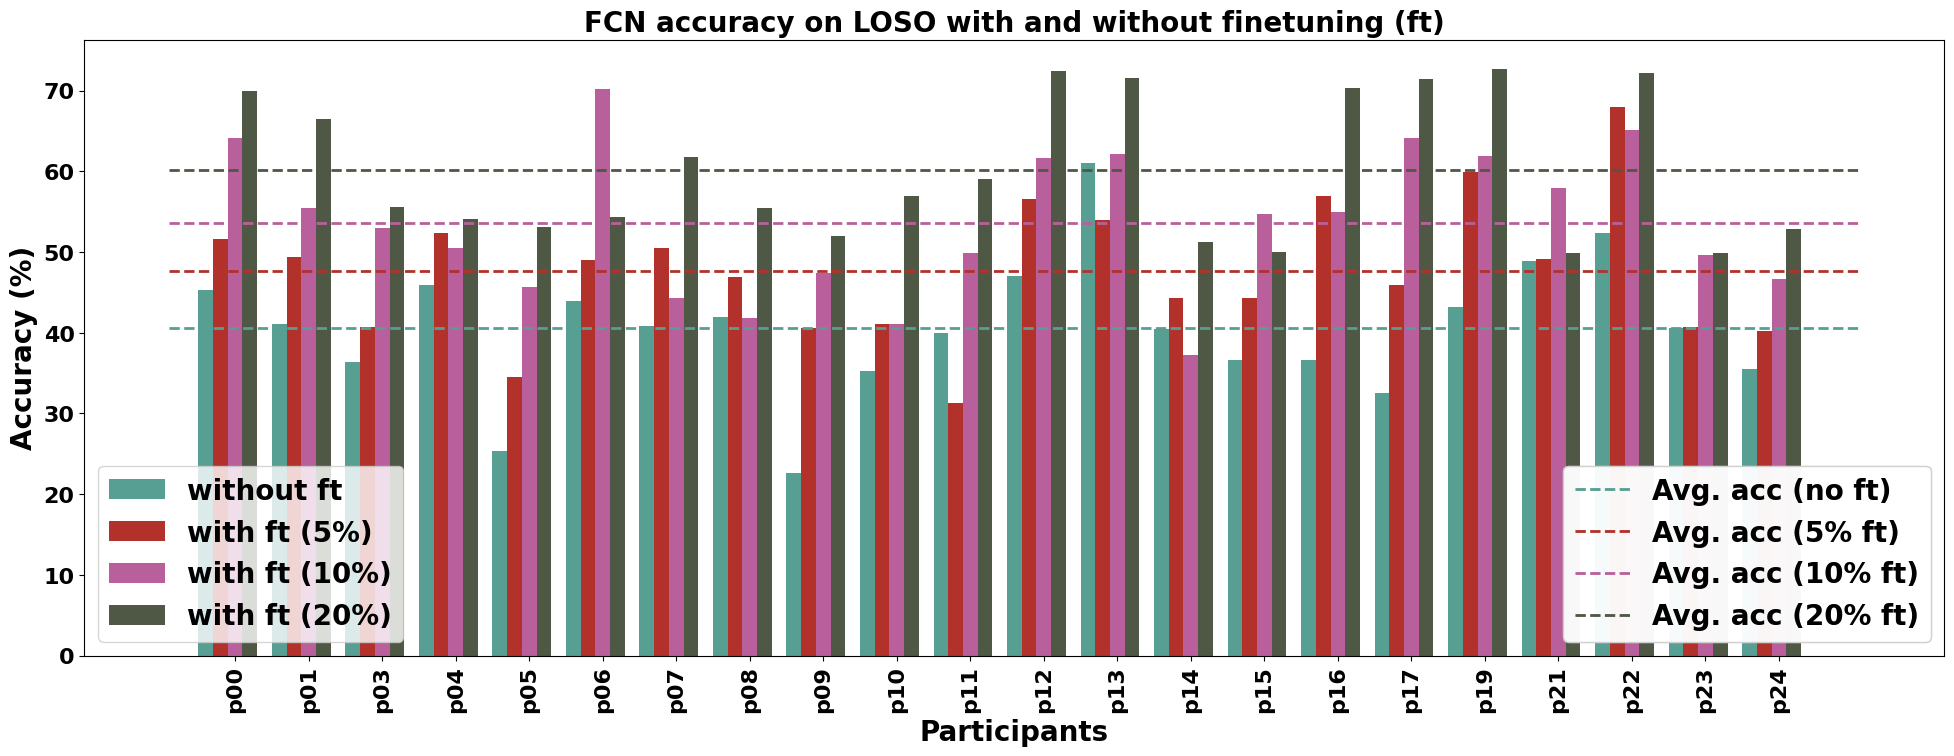

In [21]:
import matplotlib.font_manager as font_manager

N = 22
ind = np.arange(N) 
width = 0.2

plt.rcParams['figure.figsize'] = [24, 8]
wo_ft = acc_w_o_ft
bar1 = plt.bar(ind, wo_ft, width, color = '#579e93')

w_ft_5 = acc_w_ft_5
bar2 = plt.bar(ind+width, w_ft_5, width, color = '#b2312b')
  
w_ft_10 = acc_w_ft_10
bar3 = plt.bar(ind+width*2, w_ft_10, width, color='#b9609c')
  
w_ft_20 = acc_w_ft_20
bar4 = plt.bar(ind+width*3, w_ft_20, width, color = '#4e5844')

font = font_manager.FontProperties(weight='bold', style='normal', size=20)

plt.xlabel("Participants",fontsize=20, fontweight='bold')
plt.ylabel('Accuracy (%)',fontsize=20, fontweight='bold')
plt.title("FCN accuracy on LOSO with and without finetuning (ft)",fontsize=20, fontweight='bold')
  
plt.xticks(ind+width*2,participants)
plt.xticks(fontsize=16, rotation=90, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')

legend1 = plt.legend( (bar1, bar2, bar3, bar4), ('without ft', 'with ft (5%)', 'with ft (10%)', 'with ft (20%)'), loc = 3, prop=font )
plt.hlines(y=(np.mean(wo_ft)), xmin=-0.5, xmax=(len(wo_ft)+0.5), colors='#579e93', lw=2, label='Avg. acc (no ft)', linestyles='--')
plt.hlines(y=(np.mean(w_ft_5)), xmin=-0.5, xmax=(len(w_ft_5)+0.5), colors='#b2312b', lw=2, label='Avg. acc (5% ft)', linestyles='--')
plt.hlines(y=(np.mean(w_ft_10)), xmin=-0.5, xmax=(len(w_ft_10)+0.5), colors='#b9609c', lw=2, label='Avg. acc (10% ft)', linestyles='--')
plt.hlines(y=(np.mean(w_ft_20)), xmin=-0.5, xmax=(len(w_ft_20)+0.5), colors='#4e5844', lw=2, label='Avg. acc (20% ft)', linestyles='--')
legend2 = plt.legend(loc = 4, prop=font)
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
#plt.savefig('fcn_LOSO_4.pdf') 
plt.show()